<a href="https://colab.research.google.com/github/Sofil1886/Finance/blob/main/%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_(LSTM_%D0%B8_FFN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [283]:
!pip install Nasdaq-Data-Link
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [284]:
import pandas as pd
import nasdaqdatalink
import pandas_datareader as pdr
import datetime
import plotly.express as px
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers
import tensorflow as tf
tf.keras.utils.to_categorical
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.losses import categorical_crossentropy
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.models import model_from_json

# Обработка данных для LSTM model_1. Таргет - месячная доходность. 
Ежемесячные данные
Входные параметры - макрофакторы + рынок долга 

In [824]:
start = datetime.datetime (1980, 1, 1)
end = datetime.datetime (2022, 7, 29)
SP500 = yf.download('^GSPC', start=start, end=end)[['Close']].resample('1BM').last() #Импортируем цены закрытия SP500 на конец каждого месяца
SP500

[*********************100%***********************]  1 of 1 completed


,Close
Date,
1980-01-31,114.160004
1980-02-29,113.660004
1980-03-31,102.089996
1980-04-30,106.290001
1980-05-30,111.239998
...,...
2022-03-31,4530.410156
2022-04-29,4131.930176
2022-05-31,4132.149902


In [825]:
#Импортируем макрофакторы, опережающие индикаторы, данные по рынку долга

                                                          ### Monetary factors ##

#Get M1 for USA  https://fred.stlouisfed.org/series/M2SL seasonly adjusted
money_serias = 'M1SL'
M1_USA = pdr.DataReader(money_serias, 'fred', start, end).resample('1BM').last()

money_serias_2 = 'M2SL'
M2_USA = pdr.DataReader(money_serias_2, 'fred', start, end).resample('1BM').last()

#Cash assets all commercial banks seasongly adjusted
cash_assets_serias = 'CASACBW027SBOG'
Cash_Assets = pdr.DataReader(cash_assets_serias, 'fred', start, end)
Cash_Assets = Cash_Assets.rename(columns={'CASACBW027SBOG':'Cash_Assets'})

# inflation year to year (monthly)  - https://data.nasdaq.com/data/RATEINF/INFLATION_USA-inflation-yoy-usa
inflation_YOY = nasdaqdatalink.get("RATEINF/INFLATION_USA", authtoken="ozjjWbTgDPPCBtBWJW7d") 
inflation_YOY = inflation_YOY.rename(columns={'Value':'inflation_YOY'})
inflation_YOY.index = pd.to_datetime(inflation_YOY .index) - pd.to_timedelta('5 day')
inflation_YOY = inflation_YOY.resample('1BM').last()
# inflation month to month
inflation_MOM = 'CPIAUCNS'
inflation_MOM  = pdr.DataReader(inflation_MOM , 'fred', start, end).resample('1BM').last()
inflation_MOM = inflation_MOM.rename(columns={'CPIAUCNS':'inflation_MOM'})
inflation_MOM['inflation_MOM'] = inflation_MOM['inflation_MOM'].pct_change()*100

# #Get balance of Fed https://fred.stlouisfed.org/series/WALCL
# balance_serias = "WALCL"
# FED_Assets = pdr.DataReader(balance_serias, 'fred', start, end)
# FED_Assets.index = pd.to_datetime(FED_Assets.index)
# FED_Assets = FED_Assets.resample("1BM").last()
# FED_Assets = FED_Assets.rename(columns = {"WALCL" : 'Total Assets of FED'}) 

                                                    ### Expectation factors ###
Consumer_Sentiment = nasdaqdatalink.get("UMICH/SOC1", authtoken="ozjjWbTgDPPCBtBWJW7d") #  индекс ожидания потребителей 
Consumer_Sentiment.index = Consumer_Sentiment.index - pd.to_timedelta('5 day')
Consumer_Sentiment = Consumer_Sentiment.rename(columns={'Index':'Consumer_Sentiment'})
Consumer_Sentiment = Consumer_Sentiment.resample('1BM').last() 

# Michigan = nasdaqdatalink.get("UMICH/SOC5", authtoken="ozjjWbTgDPPCBtBWJW7d") # Индикаторы от Мичиганского университета 
# Michigan.index = Michigan.index - pd.to_timedelta('5 day')
# Michigan = Michigan.resample('1BM').last()

Shorts = nasdaqdatalink.get("CFTC/13874A_FO_L_ALL", authtoken="ozjjWbTgDPPCBtBWJW7d")[['Noncommercial Short']] #Объем коротких позиций - индикатор, который использует Олейник

thirty_Y_bonds = yf.download('^TYX', start=start, end=end)[['Close']].rename(columns={'Close':'thirty_Y_bonds'}) #Доходность 30-летних облигаций
ten_Y_bonds = yf.download('^TNX', start=start, end=end)[['Close']].rename(columns={'Close':'ten_Y_bonds'}) #Доходность 10-летних облигаций
five_Y_bonds = yf.download('^FVX', start=start, end=end)[['Close']].rename(columns={'Close':'five_Y_bonds'}) #Доходность 5-летних облигаций
three_M_bonds = yf.download('^IRX', start=start, end=end)[['Close']].rename(columns={'Close':'three_M_bonds'}) #Доходность 3-месячных облигаций

spread_between_10Y_and_2Y = nasdaqdatalink.get("FRED/T10Y2Y", authtoken="ozjjWbTgDPPCBtBWJW7d") # Спред между 10-летними и 2-х летними облигациями 
spread_between_10Y_and_2Y = spread_between_10Y_and_2Y.rename(columns={'Value':'spread_between_10Y_and_2Y'})

High_yield_bonds = nasdaqdatalink.get("ML/USTRI", authtoken="ozjjWbTgDPPCBtBWJW7d") # Доходность мусорных облигаций
High_yield_bonds = High_yield_bonds.rename(columns={'BAMLH0A0HYM2EY':'High_yield_bonds'})


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [826]:
Dataframe = SP500.copy()
features = [M1_USA, M2_USA, Cash_Assets, inflation_YOY, inflation_MOM, Consumer_Sentiment, Shorts, spread_between_10Y_and_2Y, thirty_Y_bonds, ten_Y_bonds, five_Y_bonds, three_M_bonds, High_yield_bonds]
for df in features:
  Dataframe = Dataframe.join(df.resample('1BM').last()) # Формирую датафрейм
Dataframe['spread_between_10Y_and_3M'] = Dataframe.ten_Y_bonds - Dataframe.three_M_bonds # Спред между 10-летними и 3-х месячными облигациями
Dataframe['change_close_price'] = Dataframe['Close'].pct_change(1) # Месячная доходность
Dataframe = Dataframe.dropna()

In [827]:
# фунция по созданию временных рядов для подачи на вход LSTM
def split_sequences(df, n_steps_in):
	X, y = list(), list()  
	for i in range(len(df)+1):
# формирую границу для временного ряда
		end_ix = i + n_steps_in
# если граница выходит за пределы датасета, то разрываю цикл
		if end_ix >= len(df+1):
			break
# формирую входные парамтеры и таргеты
		seq_x, seq_y = df.iloc[i:end_ix, :], df.iloc[end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [828]:
inputs, outputs = split_sequences(Dataframe, 3) 
print(inputs.shape)
print(outputs.shape)

(296, 3, 16)
(296,)


In [829]:
# делим датасет на train, validation и test
train_X = inputs[:int(inputs.shape[0]*0.65)]
train_y = outputs[:int(outputs.shape[0]*0.65)]
val_X = inputs[int(inputs.shape[0]*0.65):int(inputs.shape[0]*0.85)]
val_y = outputs[int(outputs.shape[0]*0.65):int(outputs.shape[0]*0.85)]
test_X = inputs[int(inputs.shape[0]*0.85):]
test_y = outputs[int(outputs.shape[0]*0.85):]  
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)
print(test_X.shape)
print(test_y.shape)

(192, 3, 16)
(192,)
(59, 3, 16)
(59,)
(45, 3, 16)
(45,)


In [830]:
# функциии для превращения датасета в двумерный массив и его стандартизация
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # формирую пустой массив
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-X.shape[1]), :] # добавляю в пустой массив данные на каждом временном шаге
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :]) # стандартизируем каждый блок с временными шагами и фичами
        
    return X

In [831]:
# Скалирование тренировчного датасета
scaler = StandardScaler().fit(flatten(train_X))
train_X_scaled = scale(train_X, scaler)
print(train_X_scaled.shape)
# проверка, чтобы все правильно отскалировалось
a = flatten(train_X_scaled)
print('mean', np.mean(a, axis=0).round(6))
print('variance', np.var(a, axis=0))
val_X_scaled = scale(val_X, scaler)
test_X_scaled = scale(test_X, scaler)
print(val_X_scaled.shape)
print(test_X_scaled.shape)


(192, 3, 16)
mean [ 0.  0. -0. -0. -0.  0.  0.  0.  0. -0.  0. -0. -0.  0. -0. -0.]
variance [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(59, 3, 16)
(45, 3, 16)


In [832]:
timesteps = train_X_scaled.shape[1]
n_features =  train_X_scaled.shape[2]
n_features

16

# Создание и обучение LSTM model_1 Таргет - месячная доходность. 
Ежемесячные данные
Входные параметры - макрофакторы + рынок долга 

In [294]:
#Строим LSTM модель. 
LSTM_1 = Sequential()
LSTM_1.add(LSTM(48, activation='tanh', return_sequences = True, input_shape = (timesteps,n_features))) 
# LSTM_1.add(BatchNormalization())
LSTM_1.add(LSTM(24, activation='tanh', return_sequences = False))
LSTM_1.add(BatchNormalization())
LSTM_1.add(Dense(12,  activation='tanh'))
LSTM_1.add(BatchNormalization())
LSTM_1.add(Dense(8,  activation='tanh'))
LSTM_1.add(Dense(1, activation='tanh'))

LSTM_1.summary()



Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 3, 48)             12480     
                                                                 
 lstm_11 (LSTM)              (None, 24)                7008      
                                                                 
 batch_normalization_11 (Bat  (None, 24)               96        
 chNormalization)                                                
                                                                 
 dense_83 (Dense)            (None, 12)                300       
                                                                 
 batch_normalization_12 (Bat  (None, 12)               48        
 chNormalization)                                                
                                                                 
 dense_84 (Dense)            (None, 8)               

In [295]:
%%time
# es = EarlyStopping(monitor='val_mae', min_delta=1e-10, patience=10, verbose=1)
# rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Сохранение весов модели с наименьшим "MAE"
weights_file = 'LSTM_1_1_weights.h5'
callback = ModelCheckpoint(weights_file,
              monitor='mae',
              mode='min',
              save_best_only=True)




CPU times: user 104 µs, sys: 7 µs, total: 111 µs
Wall time: 119 µs


In [296]:
adam = keras.optimizers.Adam(0.001)
LSTM_1.compile(optimizer=adam,loss = 'mse', metrics=['mae'])

hist_1 = LSTM_1.fit(train_X_scaled, train_y, epochs=20, 
                                                batch_size=1, 
                                                validation_data=(val_X_scaled, val_y),
                                                verbose=2, 
                  shuffle=False,
                  callbacks=[callback])

Epoch 1/20
192/192 - 12s - loss: 0.0023 - mae: 0.0365 - val_loss: 0.5240 - val_mae: 0.7220 - 12s/epoch - 64ms/step
Epoch 2/20
192/192 - 2s - loss: 0.0022 - mae: 0.0362 - val_loss: 0.7667 - val_mae: 0.8644 - 2s/epoch - 9ms/step
Epoch 3/20
192/192 - 2s - loss: 0.0022 - mae: 0.0361 - val_loss: 0.4238 - val_mae: 0.5751 - 2s/epoch - 9ms/step
Epoch 4/20
192/192 - 2s - loss: 0.0022 - mae: 0.0360 - val_loss: 0.1379 - val_mae: 0.2793 - 2s/epoch - 9ms/step
Epoch 5/20
192/192 - 2s - loss: 0.0022 - mae: 0.0360 - val_loss: 0.0926 - val_mae: 0.2235 - 2s/epoch - 9ms/step
Epoch 6/20
192/192 - 2s - loss: 0.0022 - mae: 0.0360 - val_loss: 0.0917 - val_mae: 0.2403 - 2s/epoch - 10ms/step
Epoch 7/20
192/192 - 2s - loss: 0.0022 - mae: 0.0360 - val_loss: 0.0753 - val_mae: 0.2247 - 2s/epoch - 11ms/step
Epoch 8/20
192/192 - 2s - loss: 0.0022 - mae: 0.0359 - val_loss: 0.0592 - val_mae: 0.2025 - 2s/epoch - 10ms/step
Epoch 9/20
192/192 - 1s - loss: 0.0022 - mae: 0.0359 - val_loss: 0.0782 - val_mae: 0.2377 - 919ms/

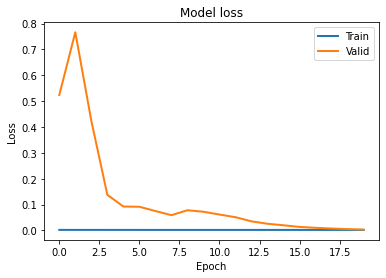

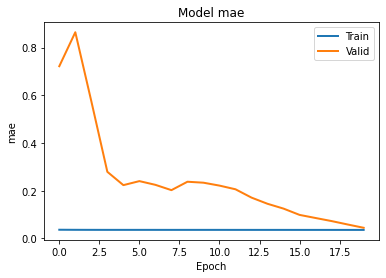

In [297]:
# Динамика ошибки MSE на обучающем и валидационном датасете
plt.plot(hist_1.history['loss'], linewidth=2, label='Train')
plt.plot(hist_1.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
# Динамика ошибки MAE на обучающем и валидационном датасете
plt.plot(hist_1.history['mae'], linewidth=2, label='Train')
plt.plot(hist_1.history['val_mae'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model mae')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.show()

In [298]:
predictions_future = LSTM_1.predict(test_X_scaled)
print(test_y)
print(predictions_future)

[ 1.78593567e-02 -9.17768947e-02  7.86844017e-02  2.97288893e-02
  1.79242562e-02  3.93134983e-02 -6.57777314e-02  6.89301640e-02
  1.31281522e-02 -1.80916272e-02  1.71811779e-02  2.04317705e-02
  3.40470377e-02  2.85898189e-02 -1.62809282e-03 -8.41104836e-02
 -1.25119282e-01  1.26844038e-01  4.52818197e-02  1.83883965e-02
  5.51013215e-02  7.00646669e-02 -3.92279702e-02 -2.76657862e-02
  1.07545635e-01  3.71214591e-02 -1.11366608e-02  2.60914514e-02
  4.24386325e-02  5.24253213e-02  5.48648867e-03  2.22140096e-02
  2.27480548e-02  2.89904163e-02 -4.75691688e-02  6.91438364e-02
 -8.33370618e-03  4.36129135e-02 -5.25851650e-02 -3.13604919e-02
  3.57732884e-02 -8.79567118e-02  5.31777046e-05 -8.39199999e-02
  7.58312396e-02]
[[-0.0194927 ]
 [ 0.0263612 ]
 [ 0.01338578]
 [-0.0751121 ]
 [-0.07869625]
 [-0.11733744]
 [ 0.02503564]
 [-0.1257845 ]
 [-0.00553138]
 [-0.12153459]
 [-0.00503037]
 [-0.1180472 ]
 [-0.10214036]
 [-0.06911115]
 [ 0.01934363]
 [-0.10462214]
 [-0.02047496]
 [ 0.0073358

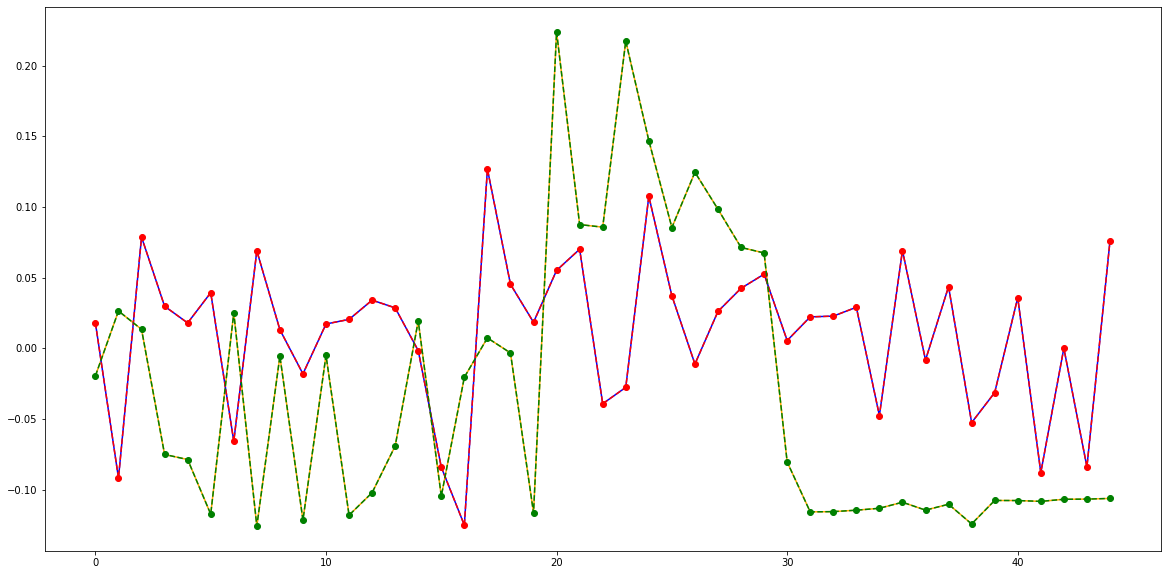

In [300]:
# График сравнения предсказаний и фактических данных
x = range(test_y.shape[0])
plt.figure(figsize=(20,10))

plt.plot(predictions_future, color='orange', label='pred') 
plt.plot(test_y, color='blue', label='true')

plt.plot(x, test_y, 'o--', color='red') #Фиолетовая линия - фактические значения
plt.plot(x, predictions_future, 'o--', color='green') #Зеленая линия - предсказание
plt.savefig('LSTM_1_1_test_graph.png')

mae: 9.69


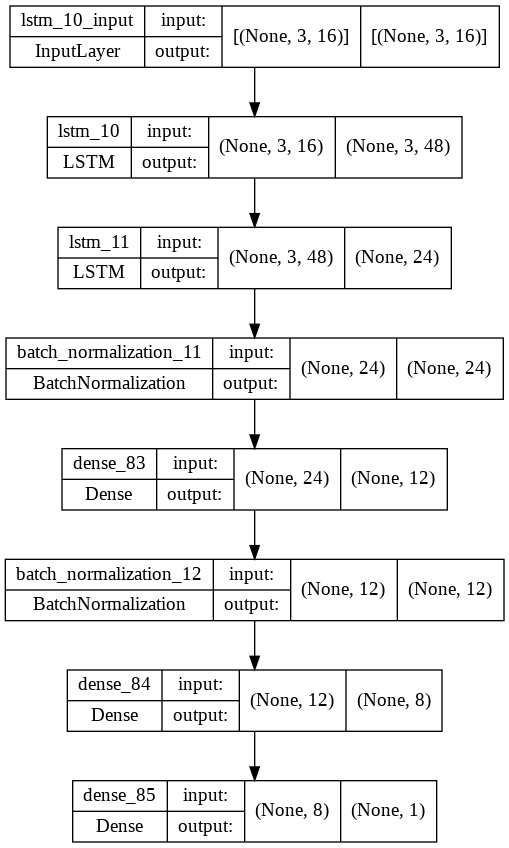

In [302]:
# Сохранение модели
json_file = 'LSTM_1_1.json'
model_json = LSTM_1.to_json()
with open(json_file, 'w') as f:
  f.write(model_json)

# Загрузка модели и присвоение ей сохраненных весов
json_file = open('LSTM_1_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("LSTM_1_1_weights.h5")

# оценка загруженной модели на тестовых данных
loaded_model.compile(loss='mse', optimizer=adam, metrics=['mae'])
score = loaded_model.evaluate(test_X_scaled, test_y, verbose=0)
print("%s: %.2f" % (loaded_model.metrics_names[1], score[1]*100))

# Визуализация построенной модели
plot_model(LSTM_1, to_file='LSTM_1_1.png', show_shapes=True, show_layer_names=True)


# Обработка данных для LSTM model_2 Таргет - цена закрытия через месяц

In [834]:
start = datetime.datetime (1980, 1, 1)
end = datetime.datetime (2022, 7, 29)
SP500 = yf.download('^GSPC', start=start, end=end)[['Close']].resample('1BM').last() #Импортируем цены закрытия SP500 на конец каждого месяца
SP500

[*********************100%***********************]  1 of 1 completed


,Close
Date,
1980-01-31,114.160004
1980-02-29,113.660004
1980-03-31,102.089996
1980-04-30,106.290001
1980-05-30,111.239998
...,...
2022-03-31,4530.410156
2022-04-29,4131.930176
2022-05-31,4132.149902


In [835]:
#Импортируем макрофакторы, опережающие индикаторы, данные по рынку долга

                                                          ### Monetary factors ##

#Get M1 for USA  https://fred.stlouisfed.org/series/M2SL seasonly adjusted
money_serias = 'M1SL'
M1_USA = pdr.DataReader(money_serias, 'fred', start, end).resample('1BM').last()

money_serias_2 = 'M2SL'
M2_USA = pdr.DataReader(money_serias_2, 'fred', start, end).resample('1BM').last()

#Cash assets all commercial banks seasongly adjusted
cash_assets_serias = 'CASACBW027SBOG'
Cash_Assets = pdr.DataReader(cash_assets_serias, 'fred', start, end)
Cash_Assets = Cash_Assets.rename(columns={'CASACBW027SBOG':'Cash_Assets'})

# inflation year to year (monthly)  - https://data.nasdaq.com/data/RATEINF/INFLATION_USA-inflation-yoy-usa
inflation_YOY = nasdaqdatalink.get("RATEINF/INFLATION_USA", authtoken="ozjjWbTgDPPCBtBWJW7d") 
inflation_YOY = inflation_YOY.rename(columns={'Value':'inflation_YOY'})
inflation_YOY.index = pd.to_datetime(inflation_YOY .index) - pd.to_timedelta('5 day')
inflation_YOY = inflation_YOY.resample('1BM').last()
# inflation month to month
inflation_MOM = 'CPIAUCNS'
inflation_MOM  = pdr.DataReader(inflation_MOM , 'fred', start, end).resample('1BM').last()
inflation_MOM = inflation_MOM.rename(columns={'CPIAUCNS':'inflation_MOM'})
inflation_MOM['inflation_MOM'] = inflation_MOM['inflation_MOM'].pct_change()*100

# #Get balance of Fed https://fred.stlouisfed.org/series/WALCL
# balance_serias = "WALCL"
# FED_Assets = pdr.DataReader(balance_serias, 'fred', start, end)
# FED_Assets.index = pd.to_datetime(FED_Assets.index)
# FED_Assets = FED_Assets.resample("1BM").last()
# FED_Assets = FED_Assets.rename(columns = {"WALCL" : 'Total Assets of FED'}) 

                                                    ### Expectation factors ###
Consumer_Sentiment = nasdaqdatalink.get("UMICH/SOC1", authtoken="ozjjWbTgDPPCBtBWJW7d") #  индекс ожидания потребителей 
Consumer_Sentiment.index = Consumer_Sentiment.index - pd.to_timedelta('5 day')
Consumer_Sentiment = Consumer_Sentiment.rename(columns={'Index':'Consumer_Sentiment'})
Consumer_Sentiment = Consumer_Sentiment.resample('1BM').last() 

# Michigan = nasdaqdatalink.get("UMICH/SOC5", authtoken="ozjjWbTgDPPCBtBWJW7d") # Индикаторы от Мичиганского университета 
# Michigan.index = Michigan.index - pd.to_timedelta('5 day')
# Michigan = Michigan.resample('1BM').last()

Shorts = nasdaqdatalink.get("CFTC/13874A_FO_L_ALL", authtoken="ozjjWbTgDPPCBtBWJW7d")[['Noncommercial Short']] #Объем коротких позиций - индикатор, который использует Олейник

thirty_Y_bonds = yf.download('^TYX', start=start, end=end)[['Close']].rename(columns={'Close':'thirty_Y_bonds'}) #Доходность 30-летних облигаций
ten_Y_bonds = yf.download('^TNX', start=start, end=end)[['Close']].rename(columns={'Close':'ten_Y_bonds'}) #Доходность 10-летних облигаций
five_Y_bonds = yf.download('^FVX', start=start, end=end)[['Close']].rename(columns={'Close':'five_Y_bonds'}) #Доходность 5-летних облигаций
three_M_bonds = yf.download('^IRX', start=start, end=end)[['Close']].rename(columns={'Close':'three_M_bonds'}) #Доходность 3-месячных облигаций

spread_between_10Y_and_2Y = nasdaqdatalink.get("FRED/T10Y2Y", authtoken="ozjjWbTgDPPCBtBWJW7d") # Спред между 10-летними и 2-х летними облигациями 
spread_between_10Y_and_2Y = spread_between_10Y_and_2Y.rename(columns={'Value':'spread_between_10Y_and_2Y'})

High_yield_bonds = nasdaqdatalink.get("ML/USTRI", authtoken="ozjjWbTgDPPCBtBWJW7d") # Доходность мусорных облигаций
High_yield_bonds = High_yield_bonds.rename(columns={'BAMLH0A0HYM2EY':'High_yield_bonds'})


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [836]:
Dataframe = SP500.copy()
features = [M1_USA, M2_USA, Cash_Assets, inflation_YOY, inflation_MOM, Consumer_Sentiment, Shorts, spread_between_10Y_and_2Y, thirty_Y_bonds, ten_Y_bonds, five_Y_bonds, three_M_bonds, High_yield_bonds]
for df in features:
  Dataframe = Dataframe.join(df.resample('1BM').last()) # Формирую датафрейм
Dataframe['spread_between_10Y_and_3M'] = Dataframe.ten_Y_bonds - Dataframe.three_M_bonds # Спред между 10-летними и 3-х месячными облигациями
Dataframe = Dataframe.dropna()

In [837]:
# фунция по созданию временных рядов для подачи на вход LSTM
def split_sequences(df, n_steps_in):
	X, y = list(), list()  
	for i in range(len(df)+1):
# формирую границу для временного ряда
		end_ix = i + n_steps_in
# если граница выходит за пределы датасета, то разрываю цикл
		if end_ix >= len(df+1):
			break
# формирую входные парамтеры и таргеты
		seq_x, seq_y = df.iloc[i:end_ix, :], df.iloc[end_ix, 0]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [838]:
inputs, outputs = split_sequences(Dataframe, 3)
print(inputs.shape)
print(outputs.shape)

(296, 3, 15)
(296,)


In [839]:
# делю датасет на train, validation и test
train_X = inputs[:int(inputs.shape[0]*0.65)]
train_y = outputs[:int(outputs.shape[0]*0.65)]
val_X = inputs[int(inputs.shape[0]*0.65):int(inputs.shape[0]*0.85)]
val_y = outputs[int(outputs.shape[0]*0.65):int(outputs.shape[0]*0.85)]
test_X = inputs[int(inputs.shape[0]*0.85):]
test_y = outputs[int(outputs.shape[0]*0.85):]  
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)
print(test_X.shape)
print(test_y.shape)

(192, 3, 15)
(192,)
(59, 3, 15)
(59,)
(45, 3, 15)
(45,)


In [840]:
# функциии для превращения датасета в двумерный массив и его стандартизация
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # формирую пустой массив
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-X.shape[1]), :] # добавляю в пустой массив данные на каждом временном шаге
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :]) # стандартизируем каждый блок с временными шагами и фичами
        
    return X

In [841]:
# Скалирование тренировчного датасета
scaler = StandardScaler().fit(flatten(train_X))
train_X_scaled = scale(train_X, scaler)
print(train_X_scaled.shape)
# проверка, чтобы все правильно отскалировалось
a = flatten(train_X_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))
val_X_scaled = scale(val_X, scaler)
test_X_scaled = scale(test_X, scaler)
print(val_X_scaled.shape)
print(test_X_scaled.shape)


(192, 3, 15)
colwise mean [ 0.  0. -0. -0. -0.  0.  0.  0.  0. -0.  0. -0. -0.  0. -0.]
colwise variance [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(59, 3, 15)
(45, 3, 15)


In [842]:
timesteps = train_X_scaled.shape[1]
n_features =  train_X_scaled.shape[2]
n_features

15

# Создание и обучение LSTM model_2 Таргет - цена закрытия через месяц. 
Ежемесячные данные
Входные параметры - макрофакторы + рынок долга 

In [393]:
#Строим LSTM модель. 
LSTM_2 = Sequential()
LSTM_2.add(LSTM(15, activation='LeakyReLU', return_sequences = True, input_shape = (timesteps,n_features)))
# LSTM_2.add(BatchNormalization())
LSTM_2.add(LSTM(15, activation='LeakyReLU', return_sequences = False))
# LSTM_2.add(BatchNormalization())
# LSTM_1.add(Dense(15,  activation='LeakyReLU'))
# LSTM_1.add(BatchNormalization())
LSTM_2.add(Dense(15,  activation='LeakyReLU'))
LSTM_2.add(Dense(1, activation='linear'))

LSTM_2.summary()



Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 3, 15)             1860      
                                                                 
 lstm_37 (LSTM)              (None, 15)                1860      
                                                                 
 dense_113 (Dense)           (None, 15)                240       
                                                                 
 dense_114 (Dense)           (None, 1)                 16        
                                                                 
Total params: 3,976
Trainable params: 3,976
Non-trainable params: 0
_________________________________________________________________


In [394]:
%%time
# es = EarlyStopping(monitor='val_mae', min_delta=1e-10, patience=10, verbose=1)
# rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
# Сохранение весов модели с наименьшим "MAE"

weights_file = 'LSTM_2_1_weights.h5'
callback = ModelCheckpoint(weights_file,
              monitor='mae',
              mode='min',
              save_best_only=True)




CPU times: user 87 µs, sys: 5 µs, total: 92 µs
Wall time: 98.2 µs


In [395]:
adam = keras.optimizers.Adam(0.0005)
LSTM_2.compile(optimizer=adam,loss = 'mse', metrics=['mae'])

hist_2 = LSTM_2.fit(train_X_scaled, train_y, epochs=20, 
                                                batch_size=1, 
                                                validation_data=(val_X_scaled, val_y),
                                                verbose=2, 
                  shuffle=False,
                  callbacks=[callback])

Epoch 1/20
192/192 - 3s - loss: 1549196.3750 - mae: 1228.2052 - val_loss: 5084850.0000 - val_mae: 2233.9150 - 3s/epoch - 17ms/step
Epoch 2/20
192/192 - 1s - loss: 1347787.3750 - mae: 1150.9042 - val_loss: 1621008.1250 - val_mae: 1236.8163 - 769ms/epoch - 4ms/step
Epoch 3/20
192/192 - 1s - loss: 355761.1250 - mae: 487.3625 - val_loss: 288173.4688 - val_mae: 436.0544 - 719ms/epoch - 4ms/step
Epoch 4/20
192/192 - 1s - loss: 307112.0625 - mae: 422.3589 - val_loss: 320033.1875 - val_mae: 455.8537 - 783ms/epoch - 4ms/step
Epoch 5/20
192/192 - 1s - loss: 179017.8594 - mae: 332.7693 - val_loss: 280581.5625 - val_mae: 424.7397 - 843ms/epoch - 4ms/step
Epoch 6/20
192/192 - 1s - loss: 105684.7812 - mae: 259.1532 - val_loss: 228414.0156 - val_mae: 380.0410 - 680ms/epoch - 4ms/step
Epoch 7/20
192/192 - 1s - loss: 61531.7617 - mae: 191.0756 - val_loss: 186117.0312 - val_mae: 342.4582 - 761ms/epoch - 4ms/step
Epoch 8/20
192/192 - 1s - loss: 45221.7695 - mae: 164.8842 - val_loss: 158607.3750 - val_mae

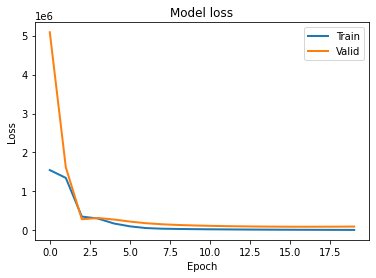

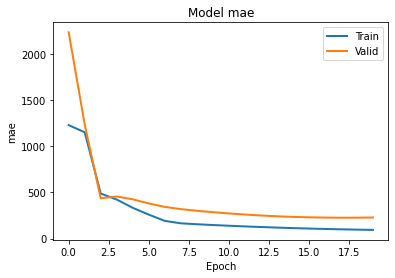

In [396]:
# Динамика ошибки MSE на обучающем и валидационном датасете
plt.plot(hist_2.history['loss'], linewidth=2, label='Train')
plt.plot(hist_2.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
# Динамика ошибки MAE на обучающем и валидационном датасете
plt.plot(hist_2.history['mae'], linewidth=2, label='Train')
plt.plot(hist_2.history['val_mae'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model mae')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.show()

In [397]:
predictions_future = LSTM_2.predict(test_X_scaled)
print(test_y)
print(predictions_future)

[2760.16992188 2506.85009766 2704.10009766 2784.48999023 2834.39990234
 2945.83007812 2752.06005859 2941.76000977 2980.37988281 2926.45996094
 2976.73999023 3037.56005859 3140.97998047 3230.7800293  3225.52001953
 2954.2199707  2584.59008789 2912.42993164 3044.31005859 3100.29003906
 3271.12011719 3500.31005859 3363.         3269.95996094 3621.62988281
 3756.07006836 3714.23999023 3811.14990234 3972.88989258 4181.16992188
 4204.10986328 4297.5        4395.25976562 4522.68017578 4307.54003906
 4605.37988281 4567.         4766.18017578 4515.54980469 4373.93994141
 4530.41015625 4131.93017578 4132.14990234 3785.37988281 4072.42993164]
[[2211.3923]
 [2115.6355]
 [1943.0594]
 [1891.6149]
 [1824.8793]
 [2123.9375]
 [2225.3333]
 [2275.251 ]
 [2321.2466]
 [2232.7283]
 [2449.8145]
 [2476.5808]
 [2574.3208]
 [2624.5715]
 [2724.712 ]
 [2781.0515]
 [2824.3218]
 [2755.4807]
 [2509.3489]
 [2645.0227]
 [3368.9043]
 [3487.5002]
 [3411.189 ]
 [3689.2646]
 [3855.317 ]
 [3582.3013]
 [3563.9924]
 [3977.93

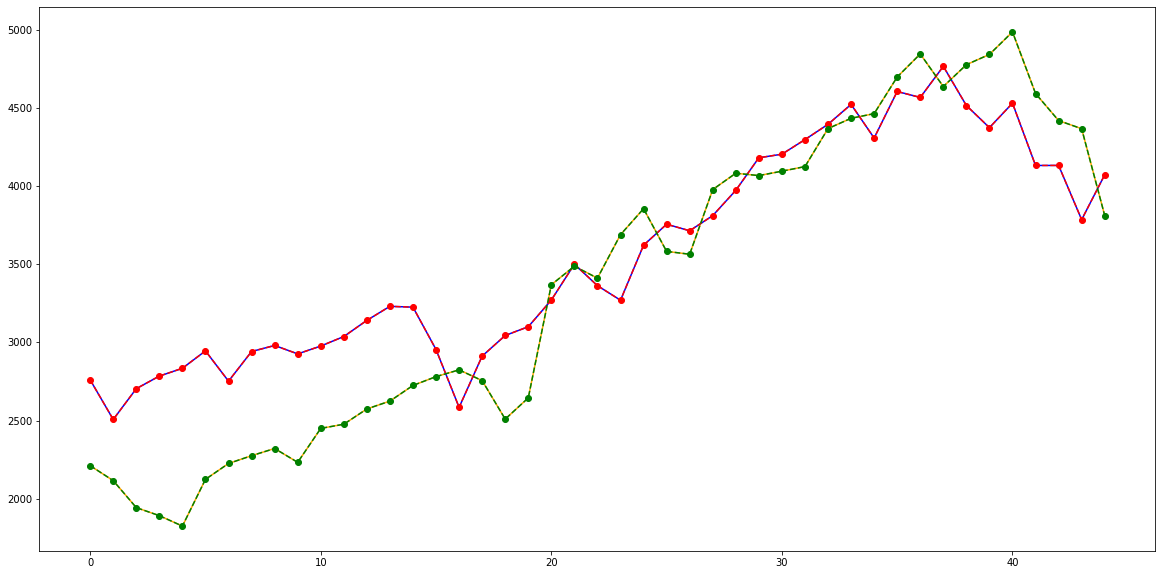

In [399]:
x = range(test_y.shape[0])
plt.figure(figsize=(20,10))

plt.plot(predictions_future, color='orange', label='pred')
plt.plot(test_y, color='blue', label='true')

plt.plot(x, test_y, 'o--', color='red')
plt.plot(x, predictions_future, 'o--', color='green')
plt.savefig('LSTM_2_1_test_graph.png')

mae: 369.96


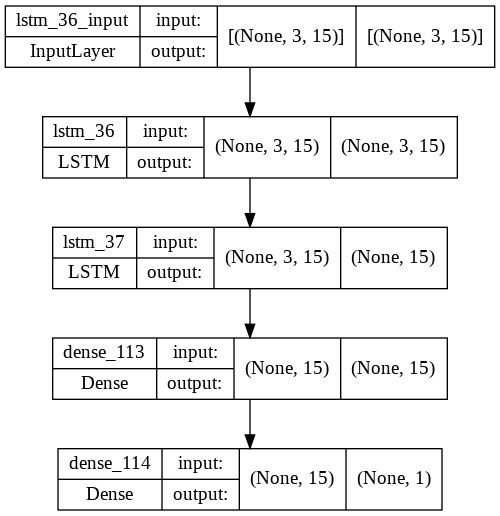

In [400]:
# Сохранение модели
json_file = 'LSTM_2_1.json'
model_json = LSTM_2.to_json()
with open(json_file, 'w') as f:
  f.write(model_json)

# Загрузка модели и присвоение ей сохраненных весов
json_file = open('LSTM_2_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("LSTM_2_1_weights.h5")

# оценка загруженной модели на тестовых данных
loaded_model.compile(loss='mse', optimizer=adam, metrics=['mae'])
score = loaded_model.evaluate(test_X_scaled, test_y, verbose=0)
print("%s: %.2f" % (loaded_model.metrics_names[1], score[1]))

# Визуализация построенной модели
plot_model(LSTM_2, to_file='LSTM_2_1.png', show_shapes=True, show_layer_names=True)


# Обработка данных для Feed_forward network_1 Таргет - месячная доходность
Макрофакторы + рынок долга, месячные данные

In [844]:
start = datetime.datetime (1980, 1, 1)
end = datetime.datetime (2022, 7, 29)
SP500 = yf.download('^GSPC', start=start, end=end)[['Close']].resample('1BM').last() #Импортируем цены закрытия SP500 на конец каждого месяца
SP500

[*********************100%***********************]  1 of 1 completed


,Close
Date,
1980-01-31,114.160004
1980-02-29,113.660004
1980-03-31,102.089996
1980-04-30,106.290001
1980-05-30,111.239998
...,...
2022-03-31,4530.410156
2022-04-29,4131.930176
2022-05-31,4132.149902


In [845]:
#Импортируем макрофакторы, опережающие индикаторы, данные по рынку долга

                                                          ### Monetary factors ##

#Get M1 for USA  https://fred.stlouisfed.org/series/M2SL seasonly adjusted
money_serias = 'M1SL'
M1_USA = pdr.DataReader(money_serias, 'fred', start, end).resample('1BM').last()

money_serias_2 = 'M2SL'
M2_USA = pdr.DataReader(money_serias_2, 'fred', start, end).resample('1BM').last()

#Cash assets all commercial banks seasongly adjusted
cash_assets_serias = 'CASACBW027SBOG'
Cash_Assets = pdr.DataReader(cash_assets_serias, 'fred', start, end)
Cash_Assets = Cash_Assets.rename(columns={'CASACBW027SBOG':'Cash_Assets'})

# inflation year to year (monthly)  - https://data.nasdaq.com/data/RATEINF/INFLATION_USA-inflation-yoy-usa
inflation_YOY = nasdaqdatalink.get("RATEINF/INFLATION_USA", authtoken="ozjjWbTgDPPCBtBWJW7d") 
inflation_YOY = inflation_YOY.rename(columns={'Value':'inflation_YOY'})
inflation_YOY.index = pd.to_datetime(inflation_YOY .index) - pd.to_timedelta('5 day')
inflation_YOY = inflation_YOY.resample('1BM').last()
# inflation month to month
inflation_MOM = 'CPIAUCNS'
inflation_MOM  = pdr.DataReader(inflation_MOM , 'fred', start, end).resample('1BM').last()
inflation_MOM = inflation_MOM.rename(columns={'CPIAUCNS':'inflation_MOM'})
inflation_MOM['inflation_MOM'] = inflation_MOM['inflation_MOM'].pct_change()*100

# #Get balance of Fed https://fred.stlouisfed.org/series/WALCL
# balance_serias = "WALCL"
# FED_Assets = pdr.DataReader(balance_serias, 'fred', start, end)
# FED_Assets.index = pd.to_datetime(FED_Assets.index)
# FED_Assets = FED_Assets.resample("1BM").last()
# FED_Assets = FED_Assets.rename(columns = {"WALCL" : 'Total Assets of FED'}) 

                                                    ### Expectation factors ###
Consumer_Sentiment = nasdaqdatalink.get("UMICH/SOC1", authtoken="ozjjWbTgDPPCBtBWJW7d") #  индекс ожидания потребителей 
Consumer_Sentiment.index = Consumer_Sentiment.index - pd.to_timedelta('5 day')
Consumer_Sentiment = Consumer_Sentiment.rename(columns={'Index':'Consumer_Sentiment'})
Consumer_Sentiment = Consumer_Sentiment.resample('1BM').last() 

# Michigan = nasdaqdatalink.get("UMICH/SOC5", authtoken="ozjjWbTgDPPCBtBWJW7d") # Индикаторы от Мичиганского университета 
# Michigan.index = Michigan.index - pd.to_timedelta('5 day')
# Michigan = Michigan.resample('1BM').last()

Shorts = nasdaqdatalink.get("CFTC/13874A_FO_L_ALL", authtoken="ozjjWbTgDPPCBtBWJW7d")[['Noncommercial Short']] #Объем коротких позиций - индикатор, который использует Олейник

thirty_Y_bonds = yf.download('^TYX', start=start, end=end)[['Close']].rename(columns={'Close':'thirty_Y_bonds'}) #Доходность 30-летних облигаций
ten_Y_bonds = yf.download('^TNX', start=start, end=end)[['Close']].rename(columns={'Close':'ten_Y_bonds'}) #Доходность 10-летних облигаций
five_Y_bonds = yf.download('^FVX', start=start, end=end)[['Close']].rename(columns={'Close':'five_Y_bonds'}) #Доходность 5-летних облигаций
three_M_bonds = yf.download('^IRX', start=start, end=end)[['Close']].rename(columns={'Close':'three_M_bonds'}) #Доходность 3-месячных облигаций

spread_between_10Y_and_2Y = nasdaqdatalink.get("FRED/T10Y2Y", authtoken="ozjjWbTgDPPCBtBWJW7d") # Спред между 10-летними и 2-х летними облигациями 
spread_between_10Y_and_2Y = spread_between_10Y_and_2Y.rename(columns={'Value':'spread_between_10Y_and_2Y'})

High_yield_bonds = nasdaqdatalink.get("ML/USTRI", authtoken="ozjjWbTgDPPCBtBWJW7d") # Доходность мусорных облигаций
High_yield_bonds = High_yield_bonds.rename(columns={'BAMLH0A0HYM2EY':'High_yield_bonds'})


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [846]:
Dataframe = SP500.copy()
features = [M1_USA, M2_USA, Cash_Assets, inflation_YOY, inflation_MOM, Consumer_Sentiment, Shorts, spread_between_10Y_and_2Y, thirty_Y_bonds, ten_Y_bonds, five_Y_bonds, three_M_bonds, High_yield_bonds]
for df in features:
  Dataframe = Dataframe.join(df.resample('1BM').last()) # Формирую датафрейм
Dataframe['spread_between_10Y_and_3M'] = Dataframe.ten_Y_bonds - Dataframe.three_M_bonds # Спред между 10-летними и 3-х месячными облигациями
Dataframe['change_close_price'] = Dataframe['Close'].pct_change(1).shift(-1) # Месячная доходность
Dataframe = Dataframe.dropna()

In [847]:
train_df = Dataframe[:int(Dataframe.shape[0]*0.65)]
val_df = Dataframe[int(Dataframe.shape[0]*0.65):int(Dataframe.shape[0]*0.85)]
test_df = Dataframe[int(Dataframe.shape[0]*0.85):]

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(193, 16)
(60, 16)
(45, 16)


In [848]:
train_X = train_df.drop(columns={'change_close_price'})
train_y = train_df.pop('change_close_price')
val_X = val_df.drop(columns={'change_close_price'})
val_y = val_df.pop('change_close_price')
test_X = test_df.drop(columns={'change_close_price'})
test_y = test_df.pop('change_close_price')  
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)
print(test_X.shape)
print(test_y.shape)

(193, 15)
(193,)
(60, 15)
(60,)
(45, 15)
(45,)


In [849]:
                           ### Нормализация данных + преобразование в array ###

train_X_sc = train_X.copy()
val_X_sc = val_X.copy()
test_X_sc = test_X.copy()
# Среднее значение
mean = train_X.mean(axis=0)
# Стандартное отклонение
std = train_X.std(axis=0)
train_X_sc -= mean
train_X_sc /= std
val_X_sc -= mean
val_X_sc /= std
test_X_sc -= mean
test_X_sc /= std


In [850]:
train_X_sc_array = np.array(train_X_sc)
val_X_sc_array = np.array(val_X_sc)
test_X_sc_array = np.array(test_X_sc)

train_y_array = np.array(train_y)
val_y_array = np.array(val_y)
test_y_array = np.array(test_y)

# Создание и обучение Feed_forward network_1 Таргет - месячная доходность
Макрофакторы + рынок долга, месячные данные

In [473]:
opt = keras.optimizers.Adam(learning_rate=0.001)
FFN_model_1 = Sequential()
FFN_model_1.add(Dense(30, activation='tanh', input_dim=train_X_sc_array.shape[1]))
FFN_model_1.add(BatchNormalization())
FFN_model_1.add(Dense(30, activation='tanh'))
FFN_model_1.add(BatchNormalization())
FFN_model_1.add(Dense(15, activation='tanh'))
FFN_model_1.add(Dense(1, activation='tanh'))
FFN_model_1.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_146 (Dense)           (None, 30)                480       
                                                                 
 batch_normalization_24 (Bat  (None, 30)               120       
 chNormalization)                                                
                                                                 
 dense_147 (Dense)           (None, 30)                930       
                                                                 
 batch_normalization_25 (Bat  (None, 30)               120       
 chNormalization)                                                
                                                                 
 dense_148 (Dense)           (None, 15)                465       
                                                                 
 dense_149 (Dense)           (None, 1)               

In [474]:
%%time
weights_file = 'FFN_1_1_weights.h5'
callback = ModelCheckpoint(weights_file,
              monitor='mae',
              mode='min',
              save_best_only=True)


CPU times: user 72 µs, sys: 4 µs, total: 76 µs
Wall time: 83.4 µs


In [475]:
FFN_model_1.compile(optimizer=opt, loss='mse', metrics=['mae'])
history_FFN_1 = FFN_model_1.fit(train_X_sc_array, 
                    train_y_array, 
                    batch_size = 1,
                    epochs=20, 
                    validation_data=(val_X_sc_array, val_y_array), 
                    verbose=2,
                    shuffle=True,
                    callbacks=[callback])

Epoch 1/20
193/193 - 1s - loss: 0.0024 - mae: 0.0374 - val_loss: 0.5155 - val_mae: 0.7043 - 1s/epoch - 8ms/step
Epoch 2/20
193/193 - 0s - loss: 0.0022 - mae: 0.0370 - val_loss: 0.2138 - val_mae: 0.3966 - 434ms/epoch - 2ms/step
Epoch 3/20
193/193 - 0s - loss: 0.0022 - mae: 0.0366 - val_loss: 0.1892 - val_mae: 0.3459 - 415ms/epoch - 2ms/step
Epoch 4/20
193/193 - 0s - loss: 0.0022 - mae: 0.0363 - val_loss: 0.1985 - val_mae: 0.3538 - 423ms/epoch - 2ms/step
Epoch 5/20
193/193 - 0s - loss: 0.0022 - mae: 0.0362 - val_loss: 0.1847 - val_mae: 0.3494 - 492ms/epoch - 3ms/step
Epoch 6/20
193/193 - 0s - loss: 0.0022 - mae: 0.0362 - val_loss: 0.1636 - val_mae: 0.3256 - 438ms/epoch - 2ms/step
Epoch 7/20
193/193 - 0s - loss: 0.0022 - mae: 0.0358 - val_loss: 0.1123 - val_mae: 0.2714 - 491ms/epoch - 3ms/step
Epoch 8/20
193/193 - 0s - loss: 0.0021 - mae: 0.0354 - val_loss: 0.1001 - val_mae: 0.2541 - 483ms/epoch - 3ms/step
Epoch 9/20
193/193 - 0s - loss: 0.0022 - mae: 0.0355 - val_loss: 0.0692 - val_mae: 

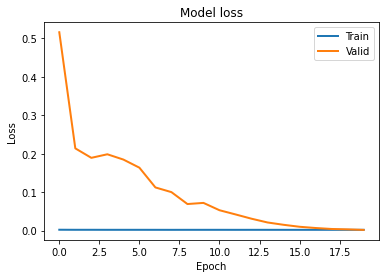

In [476]:
plt.plot(history_FFN_1.history['loss'], linewidth=2, label='Train')
plt.plot(history_FFN_1.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [477]:
scores = FFN_model_1.evaluate(test_X_sc_array, test_y_array)
print(scores[1])

2/2 [==============================] - 0s 8ms/step - loss: 0.0033 - mae: 0.0469
0.046888742595911026


In [478]:
predictions_future = FFN_model_1.predict(test_X_sc_array)

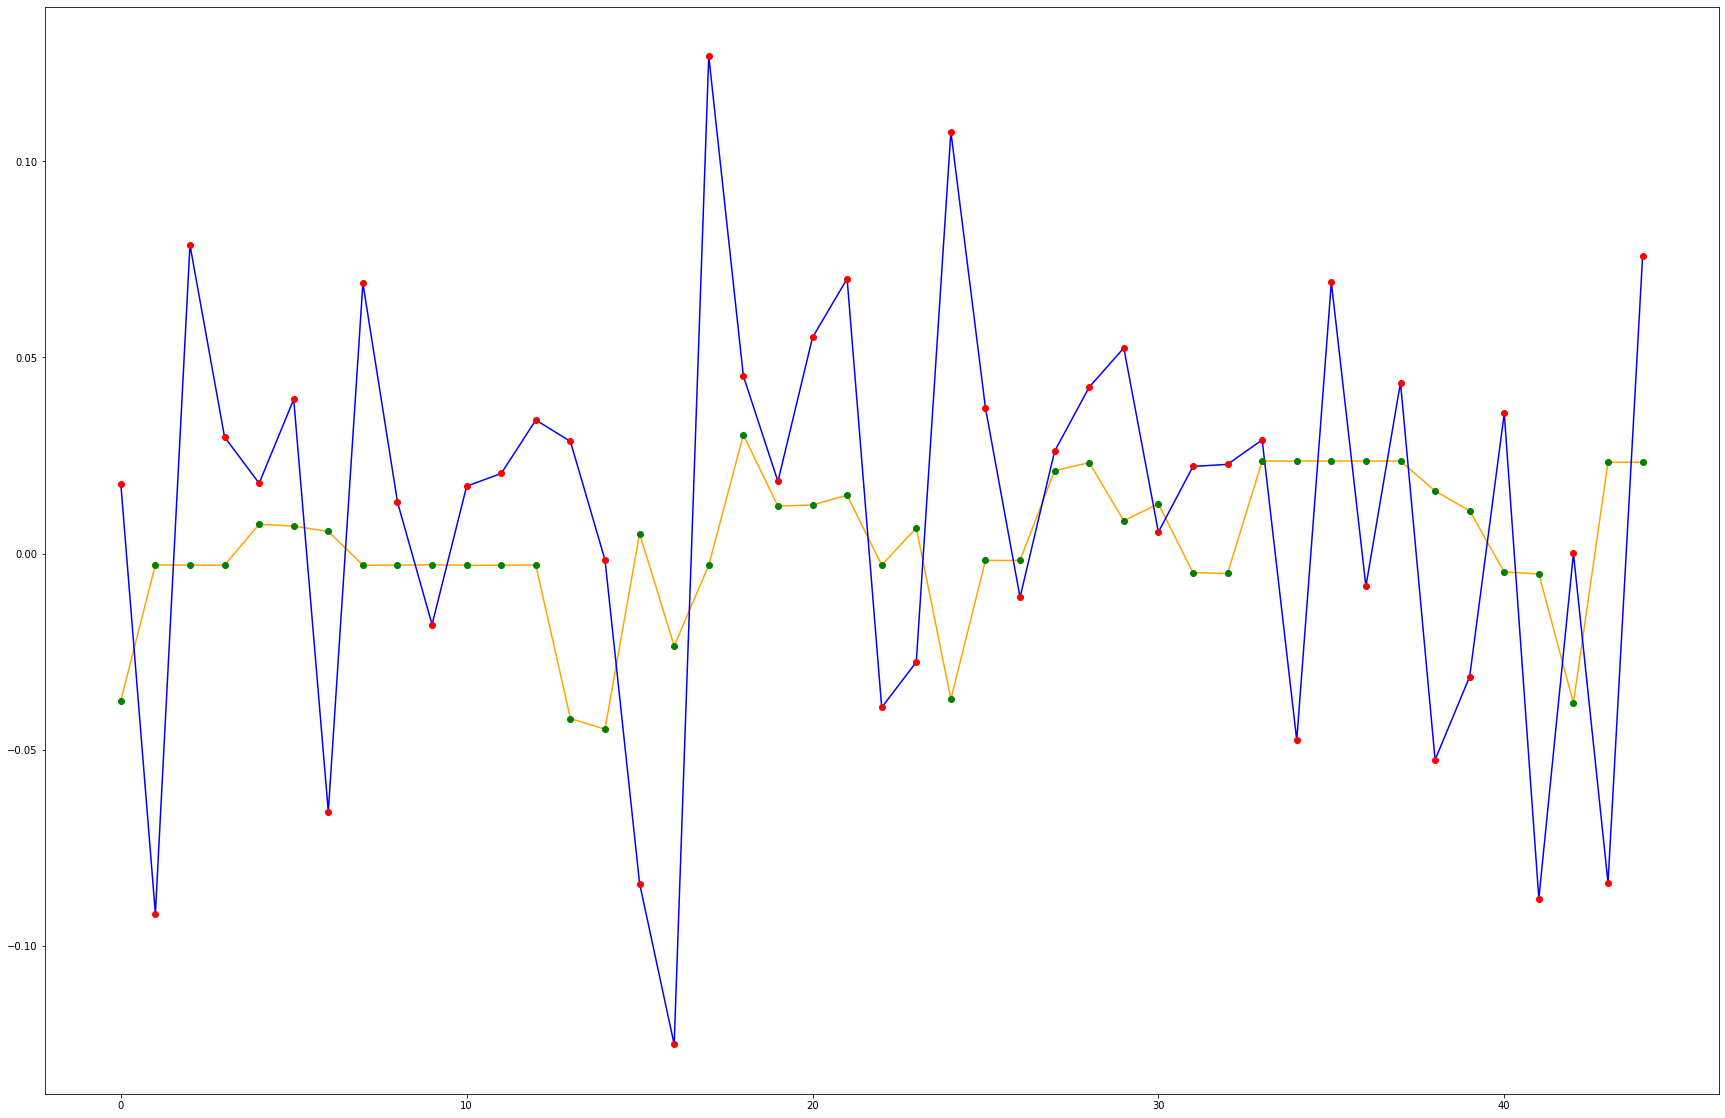

In [479]:
x = range(test_y.shape[0])
plt.figure(figsize=(30,20))

plt.plot(predictions_future, color='orange', label='pred')
plt.plot(test_y_array, color='blue', label='true')

plt.plot(x, test_y_array, 'o', color='red')
plt.plot(x, predictions_future, 'o', color='green')
plt.savefig('FFN_model_1_1_graph.png')

mae: 0.05


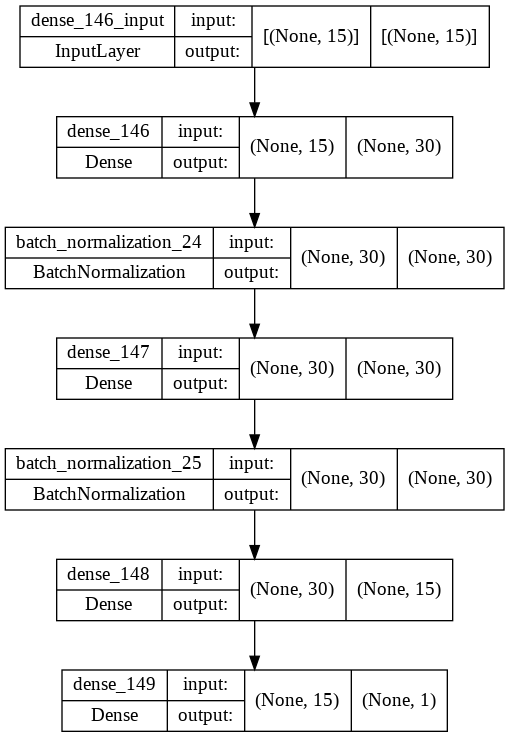

In [480]:
# Сохранение модели
json_file = 'FFN_model_1.json'
model_json = FFN_model_1.to_json()
with open(json_file, 'w') as f:
  f.write(model_json)

# Загрузка модели и присвоение ей сохраненных весов
json_file = open('FFN_model_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("FFN_1_1_weights.h5")

# оценка загруженной модели на тестовых данных
loaded_model.compile(loss='mse', optimizer=adam, metrics=['mae'])
score = loaded_model.evaluate(test_X_sc_array, test_y_array, verbose=0)
print("%s: %.2f" % (loaded_model.metrics_names[1], score[1]))

# Визуализация построенной модели
plot_model(FFN_model_1, to_file='FFN_model_1.png', show_shapes=True, show_layer_names=True)


# Обработка данных для Feed_forward network_2 Таргет - цена закрытия через месяц
Макрофакторы + рынок долга

In [853]:
start = datetime.datetime (1980, 1, 1)
end = datetime.datetime (2022, 7, 29)
SP500 = yf.download('^GSPC', start=start, end=end)[['Close']].resample('1BM').last() #Импортируем цены закрытия SP500 на конец каждого месяца
SP500

[*********************100%***********************]  1 of 1 completed


,Close
Date,
1980-01-31,114.160004
1980-02-29,113.660004
1980-03-31,102.089996
1980-04-30,106.290001
1980-05-30,111.239998
...,...
2022-03-31,4530.410156
2022-04-29,4131.930176
2022-05-31,4132.149902


In [854]:
#Импортируем макрофакторы, опережающие индикаторы, данные рынку долга

                                                          ### Money factors ##

#Get M1 for USA  https://fred.stlouisfed.org/series/M2SL seasonly adjusted
money_serias = 'M1SL'
M1_USA = pdr.DataReader(money_serias, 'fred', start, end).resample('1BM').last()

money_serias_2 = 'M2SL'
M2_USA = pdr.DataReader(money_serias_2, 'fred', start, end).resample('1BM').last()


#Cash assets all commercial banks seasongly adjusted
cash_assets_serias = 'CASACBW027SBOG'
Cash_Assets = pdr.DataReader(cash_assets_serias, 'fred', start, end)
Cash_Assets = Cash_Assets.rename(columns={'CASACBW027SBOG':'Cash_Assets'})


                                                    ### Expectation factors ###
Consumer_Sentiment = nasdaqdatalink.get("UMICH/SOC1", authtoken="ozjjWbTgDPPCBtBWJW7d") #  индекс ожидания потребителей 
Consumer_Sentiment.index = Consumer_Sentiment.index - pd.to_timedelta('5 day')
Consumer_Sentiment = Consumer_Sentiment.rename(columns={'Index':'Consumer_Sentiment'})
Consumer_Sentiment = Consumer_Sentiment.resample('1BM').last() 

# Michigan = nasdaqdatalink.get("UMICH/SOC5", authtoken="ozjjWbTgDPPCBtBWJW7d") # Индикаторы от Мичиганского университета 
# Michigan.index = Michigan.index - pd.to_timedelta('5 day')
# Michigan = Michigan.resample('1BM').last()

Shorts = nasdaqdatalink.get("CFTC/13874A_FO_L_ALL", authtoken="ozjjWbTgDPPCBtBWJW7d")[['Noncommercial Short']] #Объем коротких позиций, индикатор, который использует Олейник

thirty_Y_bonds = yf.download('^TYX', start=start, end=end)[['Close']].rename(columns={'Close':'thirty_Y_bonds'}) #Доходность 30-летних облигаций
ten_Y_bonds = yf.download('^TNX', start=start, end=end)[['Close']].rename(columns={'Close':'ten_Y_bonds'}) #Доходность 10-летних облигаций
five_Y_bonds = yf.download('^FVX', start=start, end=end)[['Close']].rename(columns={'Close':'five_Y_bonds'}) #Доходность 5-летних облигаций
three_M_bonds = yf.download('^IRX', start=start, end=end)[['Close']].rename(columns={'Close':'three_M_bonds'}) #Доходность 3-месячных облигаций

spread_between_10Y_and_2Y = nasdaqdatalink.get("FRED/T10Y2Y", authtoken="ozjjWbTgDPPCBtBWJW7d") # Спред между 10-летними и 2-х летними облигациями 
spread_between_10Y_and_2Y = spread_between_10Y_and_2Y.rename(columns={'Value':'spread_between_10Y_and_2Y'})

High_yield_bonds = nasdaqdatalink.get("ML/USTRI", authtoken="ozjjWbTgDPPCBtBWJW7d") # Доходность мусорных облигаций
High_yield_bonds = High_yield_bonds.rename(columns={'BAMLH0A0HYM2EY':'High_yield_bonds'})


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [855]:
Dataframe = SP500.copy()
features = [M1_USA, M2_USA, Cash_Assets, Consumer_Sentiment, Shorts, spread_between_10Y_and_2Y, thirty_Y_bonds, ten_Y_bonds, five_Y_bonds, three_M_bonds, High_yield_bonds]
for df in features:
  Dataframe = Dataframe.join(df.resample('1BM').last()) # Формирую датафрейм
Dataframe['spread_between_10Y_and_3M'] = Dataframe.ten_Y_bonds - Dataframe.three_M_bonds # Спред между 10-летними и 3-х месячными облигациями
Dataframe['Close_prediction'] = Dataframe['Close'].shift(-1) # цена закрытия через месяц
Dataframe = Dataframe.dropna()

In [856]:
train_df = Dataframe[:int(Dataframe.shape[0]*0.65)]
val_df = Dataframe[int(Dataframe.shape[0]*0.65):int(Dataframe.shape[0]*0.85)]
test_df = Dataframe[int(Dataframe.shape[0]*0.85):]

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(193, 14)
(60, 14)
(45, 14)


In [857]:
train_X = train_df.drop(columns={'Close_prediction'})
train_y = train_df.pop('Close_prediction')
val_X = val_df.drop(columns={'Close_prediction'})
val_y = val_df.pop('Close_prediction')
test_X = test_df.drop(columns={'Close_prediction'})
test_y = test_df.pop('Close_prediction')  
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)
print(test_X.shape)
print(test_y.shape)

(193, 13)
(193,)
(60, 13)
(60,)
(45, 13)
(45,)


In [858]:
                           ### Нормализация данных + преобразование в array ###

train_X_sc = train_X.copy()
val_X_sc = val_X.copy()
test_X_sc = test_X.copy()
# Среднее значение
mean = train_X.mean(axis=0)
# Стандартное отклонение
std = train_X.std(axis=0)
train_X_sc -= mean
train_X_sc /= std
val_X_sc -= mean
val_X_sc /= std
test_X_sc -= mean
test_X_sc /= std


In [859]:
train_X_sc_array = np.array(train_X_sc)
val_X_sc_array = np.array(val_X_sc)
test_X_sc_array = np.array(test_X_sc)

train_y_array = np.array(train_y)
val_y_array = np.array(val_y)
test_y_array = np.array(test_y)

# Создание и обучение Feed_forward network_2 Таргет - цена закрытия через месяц
Макрофакторы + рынок долга

In [683]:
opt = keras.optimizers.Adam(learning_rate=0.001)
FFN_model_2 = Sequential()
FFN_model_2.add(Dense(30, activation='LeakyReLU', input_dim=train_X_sc_array.shape[1]))
# FFN_model_2.add(BatchNormalization())
FFN_model_2.add(Dense(15, activation='LeakyReLU'))
FFN_model_2.add(Dense(15, activation='relu'))
FFN_model_2.add(Dense(1, activation='linear'))
FFN_model_2.summary()

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_263 (Dense)           (None, 30)                420       
                                                                 
 dense_264 (Dense)           (None, 15)                465       
                                                                 
 dense_265 (Dense)           (None, 15)                240       
                                                                 
 dense_266 (Dense)           (None, 1)                 16        
                                                                 
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
_________________________________________________________________


In [512]:
%%time
weights_file = 'FFN_2_1_weights.h5'
callback = ModelCheckpoint(weights_file,
              monitor='mae',
              mode='min',
              save_best_only=True)


CPU times: user 134 µs, sys: 7 µs, total: 141 µs
Wall time: 150 µs


In [513]:
FFN_model_2.compile(optimizer=opt, loss='mse', metrics=['mae'])
history_2 = FFN_model_2.fit(train_X_sc_array, 
                    train_y_array, 
                    batch_size = 1,
                    epochs=20, 
                    validation_data=(val_X_sc_array, val_y_array), 
                    verbose=2,
                    shuffle=True,
                    callbacks=[callback])

Epoch 1/20
193/193 - 1s - loss: 1526745.7500 - mae: 1219.4707 - val_loss: 5044418.0000 - val_mae: 2224.4167 - 1s/epoch - 5ms/step
Epoch 2/20
193/193 - 0s - loss: 1331776.6250 - mae: 1135.4672 - val_loss: 4359487.0000 - val_mae: 2063.8230 - 425ms/epoch - 2ms/step
Epoch 3/20
193/193 - 0s - loss: 566909.5625 - mae: 679.1627 - val_loss: 1190096.7500 - val_mae: 1037.8923 - 496ms/epoch - 3ms/step
Epoch 4/20
193/193 - 0s - loss: 92473.6094 - mae: 251.6140 - val_loss: 408381.4688 - val_mae: 530.0545 - 416ms/epoch - 2ms/step
Epoch 5/20
193/193 - 0s - loss: 50209.1289 - mae: 182.7850 - val_loss: 584732.7500 - val_mae: 686.4407 - 413ms/epoch - 2ms/step
Epoch 6/20
193/193 - 0s - loss: 32753.5078 - mae: 144.4524 - val_loss: 455803.1562 - val_mae: 598.2217 - 371ms/epoch - 2ms/step
Epoch 7/20
193/193 - 0s - loss: 24150.7051 - mae: 118.6301 - val_loss: 412693.2188 - val_mae: 573.9524 - 378ms/epoch - 2ms/step
Epoch 8/20
193/193 - 0s - loss: 18132.9336 - mae: 103.4340 - val_loss: 364978.9375 - val_mae: 

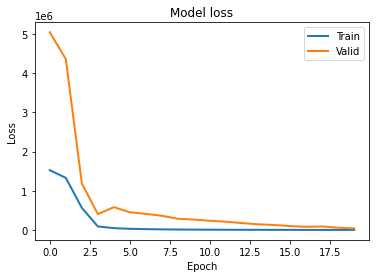

In [514]:
plt.plot(history_2.history['loss'], linewidth=2, label='Train')
plt.plot(history_2.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [515]:
scores = FFN_model_2.evaluate(test_X_sc_array, test_y_array)
print(scores[1])

2/2 [==============================] - 0s 7ms/step - loss: 123152.4766 - mae: 307.0711
307.0710754394531


In [516]:
predictions_future = FFN_model_2.predict(test_X_sc_array)

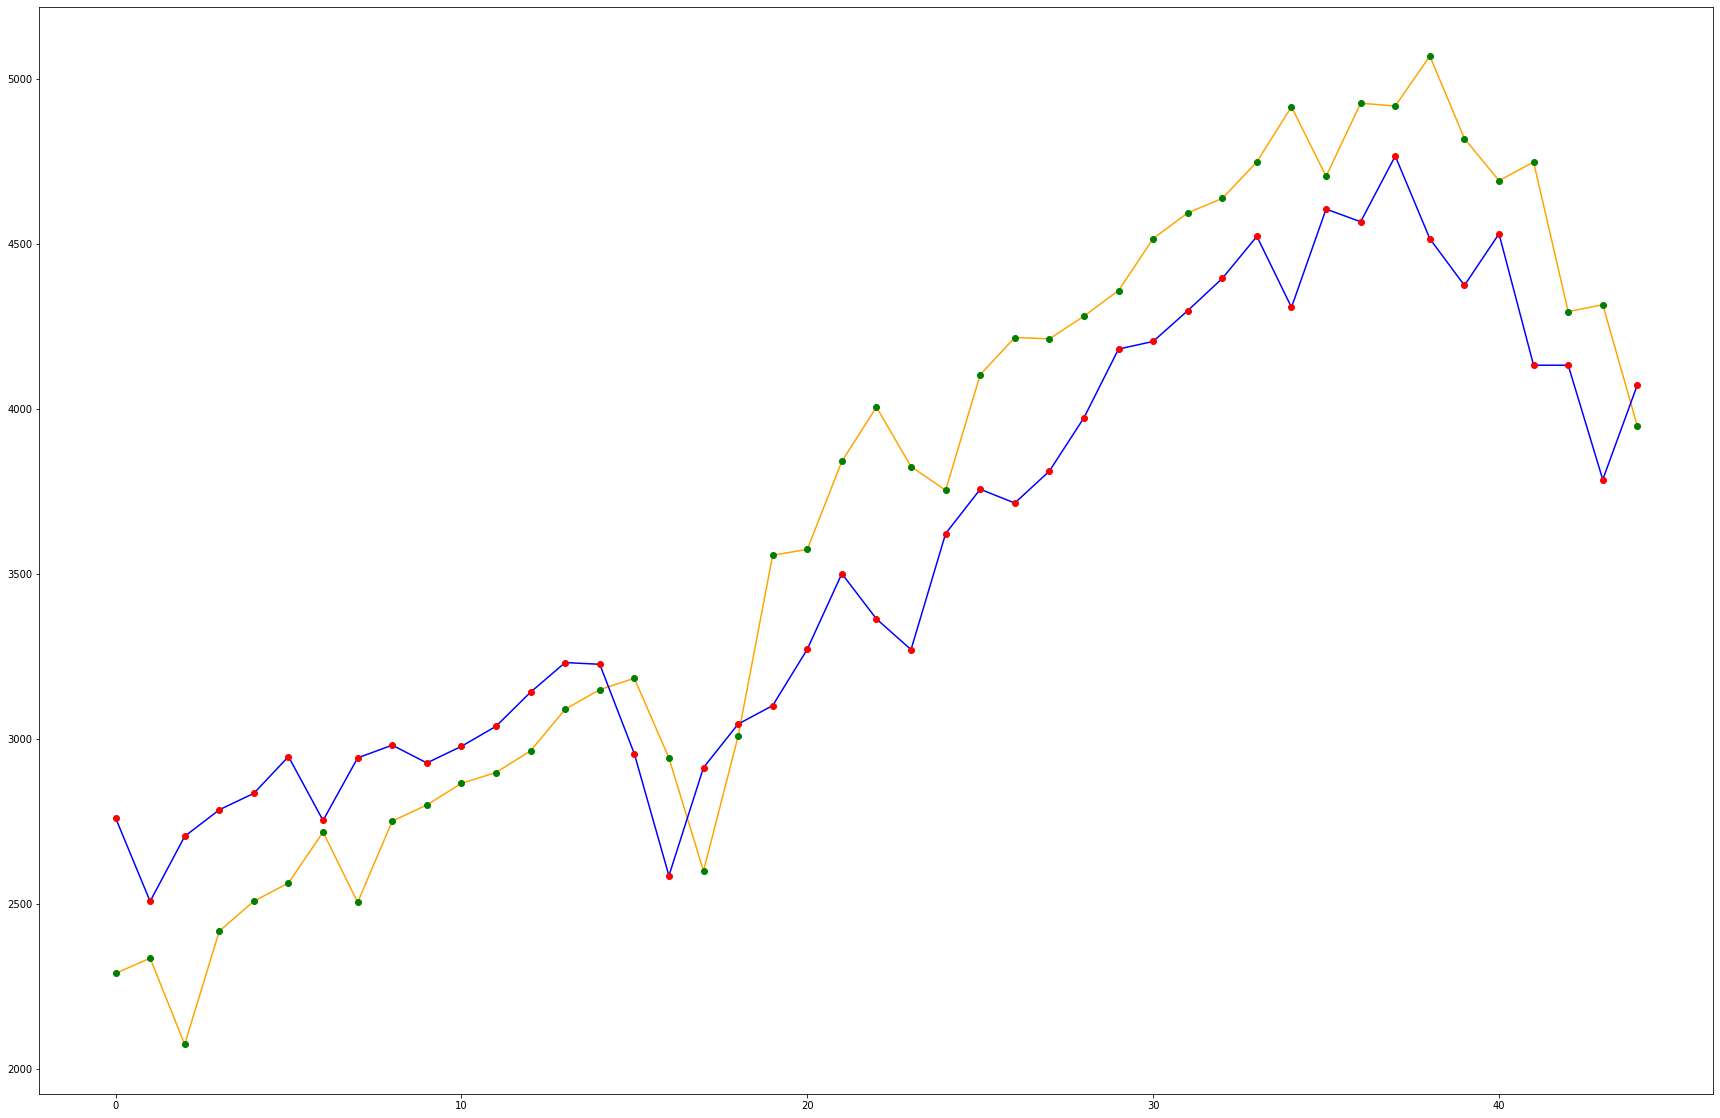

In [519]:
x = range(test_y.shape[0])
plt.figure(figsize=(30,20))

plt.plot(predictions_future, color='orange', label='pred')
plt.plot(test_y_array, color='blue', label='true')

plt.plot(x, test_y_array, 'o', color='red')
plt.plot(x, predictions_future, 'o', color='green')
plt.savefig('FFN_2_1_graph.png')

mae: 307.07


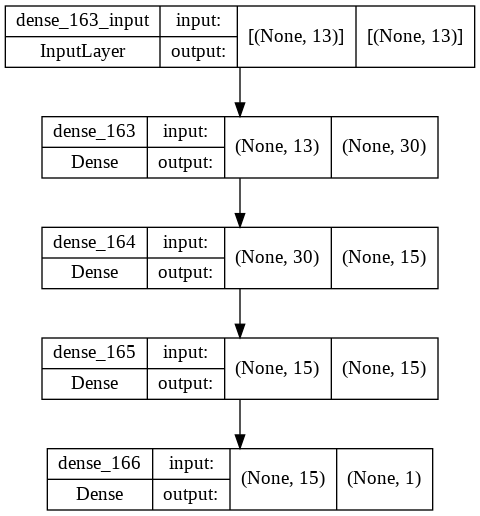

In [518]:
# Сохранение модели
json_file = 'FFN_2_1.json'
model_json = FFN_model_2.to_json()
with open(json_file, 'w') as f:
  f.write(model_json)

# Загрузка модели и присвоение ей сохраненных весов
json_file = open('FFN_2_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("FFN_2_1_weights.h5")

# оценка загруженной модели на тестовых данных
loaded_model.compile(loss='mse', optimizer=adam, metrics=['mae'])
score = loaded_model.evaluate(test_X_sc_array, test_y_array, verbose=0)
print("%s: %.2f" % (loaded_model.metrics_names[1], score[1]))

# Визуализация построенной модели
plot_model(FFN_model_2, to_file='FFN_2_1.png', show_shapes=True, show_layer_names=True)


# Обработка данных для Feed_forward network_3 Таргет - движение цены
Макрофакторы + Рынок долга (ежемесячно)

In [812]:
start = datetime.datetime (1980, 1, 1)
end = datetime.datetime (2022, 7, 29)
SP500 = yf.download('^GSPC', start=start, end=end)[['Close']].resample('1BM').last() #Импортируем цены закрытия SP500 на конец каждого месяца
SP500

[*********************100%***********************]  1 of 1 completed


,Close
Date,
1980-01-31,114.160004
1980-02-29,113.660004
1980-03-31,102.089996
1980-04-30,106.290001
1980-05-30,111.239998
...,...
2022-03-31,4530.410156
2022-04-29,4131.930176
2022-05-31,4132.149902


In [813]:
#Импортируем макрофакторы, опережающие индикаторы, данные по рынку долга

                                                          ### Monetary factors ##

#Get M1 for USA  https://fred.stlouisfed.org/series/M2SL seasonly adjusted
money_serias = 'M1SL'
M1_USA = pdr.DataReader(money_serias, 'fred', start, end).resample('1BM').last()

money_serias_2 = 'M2SL'
M2_USA = pdr.DataReader(money_serias_2, 'fred', start, end).resample('1BM').last()

#Cash assets all commercial banks seasongly adjusted
cash_assets_serias = 'CASACBW027SBOG'
Cash_Assets = pdr.DataReader(cash_assets_serias, 'fred', start, end)
Cash_Assets = Cash_Assets.rename(columns={'CASACBW027SBOG':'Cash_Assets'})

# inflation year to year (monthly)  - https://data.nasdaq.com/data/RATEINF/INFLATION_USA-inflation-yoy-usa
inflation_YOY = nasdaqdatalink.get("RATEINF/INFLATION_USA", authtoken="ozjjWbTgDPPCBtBWJW7d") 
inflation_YOY = inflation_YOY.rename(columns={'Value':'inflation_YOY'})
inflation_YOY.index = pd.to_datetime(inflation_YOY .index) - pd.to_timedelta('5 day')
inflation_YOY = inflation_YOY.resample('1BM').last()
# inflation month to month
inflation_MOM = 'CPIAUCNS'
inflation_MOM  = pdr.DataReader(inflation_MOM , 'fred', start, end).resample('1BM').last()
inflation_MOM = inflation_MOM.rename(columns={'CPIAUCNS':'inflation_MOM'})
inflation_MOM['inflation_MOM'] = inflation_MOM['inflation_MOM'].pct_change()*100

# #Get balance of Fed https://fred.stlouisfed.org/series/WALCL
# balance_serias = "WALCL"
# FED_Assets = pdr.DataReader(balance_serias, 'fred', start, end)
# FED_Assets.index = pd.to_datetime(FED_Assets.index)
# FED_Assets = FED_Assets.resample("1BM").last()
# FED_Assets = FED_Assets.rename(columns = {"WALCL" : 'Total Assets of FED'}) 

                                                    ### Expectation factors ###
Consumer_Sentiment = nasdaqdatalink.get("UMICH/SOC1", authtoken="ozjjWbTgDPPCBtBWJW7d") #  индекс ожидания потребителей 
Consumer_Sentiment.index = Consumer_Sentiment.index - pd.to_timedelta('5 day')
Consumer_Sentiment = Consumer_Sentiment.rename(columns={'Index':'Consumer_Sentiment'})
Consumer_Sentiment = Consumer_Sentiment.resample('1BM').last() 

# Michigan = nasdaqdatalink.get("UMICH/SOC5", authtoken="ozjjWbTgDPPCBtBWJW7d") # Индикаторы от Мичиганского университета 
# Michigan.index = Michigan.index - pd.to_timedelta('5 day')
# Michigan = Michigan.resample('1BM').last()

Shorts = nasdaqdatalink.get("CFTC/13874A_FO_L_ALL", authtoken="ozjjWbTgDPPCBtBWJW7d")[['Noncommercial Short']] #Объем коротких позиций - индикатор, который использует Олейник

thirty_Y_bonds = yf.download('^TYX', start=start, end=end)[['Close']].rename(columns={'Close':'thirty_Y_bonds'}) #Доходность 30-летних облигаций
ten_Y_bonds = yf.download('^TNX', start=start, end=end)[['Close']].rename(columns={'Close':'ten_Y_bonds'}) #Доходность 10-летних облигаций
five_Y_bonds = yf.download('^FVX', start=start, end=end)[['Close']].rename(columns={'Close':'five_Y_bonds'}) #Доходность 5-летних облигаций
three_M_bonds = yf.download('^IRX', start=start, end=end)[['Close']].rename(columns={'Close':'three_M_bonds'}) #Доходность 3-месячных облигаций

spread_between_10Y_and_2Y = nasdaqdatalink.get("FRED/T10Y2Y", authtoken="ozjjWbTgDPPCBtBWJW7d") # Спред между 10-летними и 2-х летними облигациями 
spread_between_10Y_and_2Y = spread_between_10Y_and_2Y.rename(columns={'Value':'spread_between_10Y_and_2Y'})

High_yield_bonds = nasdaqdatalink.get("ML/USTRI", authtoken="ozjjWbTgDPPCBtBWJW7d") # Доходность мусорных облигаций
High_yield_bonds = High_yield_bonds.rename(columns={'BAMLH0A0HYM2EY':'High_yield_bonds'})


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [814]:
Dataframe = SP500.copy()
features = [M1_USA, M2_USA, Cash_Assets, inflation_YOY,  inflation_MOM, Consumer_Sentiment, Shorts, spread_between_10Y_and_2Y, thirty_Y_bonds, ten_Y_bonds, five_Y_bonds, three_M_bonds, High_yield_bonds]
for df in features:
  Dataframe = Dataframe.join(df.resample('1BM').last()) # Формирую датафрейм
Dataframe['spread_between_10Y_and_3M'] = Dataframe.ten_Y_bonds - Dataframe.three_M_bonds # Спред между 10-летними и 3-х месячными облигациями
Dataframe['change_close_price'] = Dataframe['Close'].pct_change(1).shift(-1) # Месячная доходность
Dataframe = Dataframe.dropna()

In [815]:
# used to classify future stock price movement
class Direction:
    UP = 2
    DOWN = 0
    STATIONARY = 1
def prep_data(df, threshold = 0.01):
    def label_data(row):
        if row['change_close_price'] >= threshold:
            return Direction.UP
        elif row['change_close_price'] < -threshold:
            return Direction.DOWN
        else:
            return Direction.STATIONARY
    df['movement_labels'] = df.apply(label_data, axis=1)
    df = df.drop(columns = 'change_close_price')
    return df

In [816]:
Dataframe_with_labels = prep_data(Dataframe)
train_df = Dataframe_with_labels[:int(Dataframe_with_labels.shape[0]*0.65)]
val_df = Dataframe_with_labels[int(Dataframe_with_labels.shape[0]*0.65):int(Dataframe_with_labels.shape[0]*0.85)]
test_df = Dataframe_with_labels[int(Dataframe_with_labels.shape[0]*0.85):]

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(193, 16)
(60, 16)
(45, 16)


In [817]:
df_class_2 = train_df[train_df['movement_labels']== 2]
df_class_1 = train_df[train_df['movement_labels']== 1]
df_class_0 = train_df[train_df['movement_labels']== 0]
print(df_class_2.shape)
print(df_class_1.shape)
print(df_class_0.shape)

(96, 16)
(31, 16)
(66, 16)


In [818]:
df_class_1_oversampled = df_class_1.sample(df_class_2.shape[0], replace=True)
df_class_0_oversampled = df_class_0.sample(df_class_2.shape[0], replace=True)
print(df_class_1_oversampled.shape)
print(df_class_2.shape)
print(df_class_0_oversampled.shape)

(96, 16)
(96, 16)
(96, 16)


In [819]:
training_set = pd.concat([df_class_1_oversampled, df_class_0_oversampled, df_class_2], axis = 0)
training_set = training_set.sort_index(ascending=True)
train_X = training_set.drop(columns={'movement_labels'})
train_y = training_set.pop('movement_labels')
val_X = val_df.drop(columns={'movement_labels'})
val_y = val_df.pop('movement_labels')
test_X = test_df.drop(columns={'movement_labels'})
test_y = test_df.pop('movement_labels')  
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)
print(test_X.shape)
print(test_y.shape)

(288, 15)
(288,)
(60, 15)
(60,)
(45, 15)
(45,)


In [820]:
                           ### Нормализация данных + преобразование в array ###

train_X_sc = train_X.copy()
val_X_sc = val_X.copy()
test_X_sc = test_X.copy()
# Среднее значение
mean = train_X.mean(axis=0)
# Стандартное отклонение
std = train_X.std(axis=0)
train_X_sc -= mean
train_X_sc /= std
val_X_sc -= mean
val_X_sc /= std
test_X_sc -= mean
test_X_sc /= std


In [821]:
train_X_sc_array = np.array(train_X_sc)
val_X_sc_array = np.array(val_X_sc)
test_X_sc_array = np.array(test_X_sc)

train_y_bin = np.array(np_utils.to_categorical(train_y, num_classes = 3))
val_y_bin = np.array(np_utils.to_categorical(val_y, num_classes = 3))
test_y_bin = np.array(np_utils.to_categorical(test_y, num_classes = 3))

# Создание и обучение модели Feed_forward network_3 Таргет - движение цены
Макрофакторы + Рынок долга (ежемесячно)

In [633]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
FFN_model_3 = Sequential()
FFN_model_3.add(Dense(30, activation='relu', input_dim=train_X_sc_array.shape[1]))
# FFN_model_3.add(Dense(30, activation='tanh'))
# FFN_model_3.add(Dense(30, activation='tanh'))
FFN_model_3.add(Dense(15, activation='relu'))
FFN_model_3.add(Dense(5, activation='tanh'))
FFN_model_3.add(Dense(3, activation='softmax'))
FFN_model_3.summary()

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_259 (Dense)           (None, 30)                480       
                                                                 
 dense_260 (Dense)           (None, 15)                465       
                                                                 
 dense_261 (Dense)           (None, 5)                 80        
                                                                 
 dense_262 (Dense)           (None, 3)                 18        
                                                                 
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________


In [634]:
%%time
callback = ModelCheckpoint('FFN_3_1_weights.h5',
              monitor='accuracy',
              mode='max',
              save_best_only=True)


CPU times: user 99 µs, sys: 0 ns, total: 99 µs
Wall time: 108 µs


In [635]:
FFN_model_3.compile(optimizer=opt, loss='CategoricalCrossentropy', metrics=['accuracy'])
history_3 = FFN_model_3.fit(train_X_sc_array, 
                    train_y_bin, 
                    batch_size =1,
                    epochs=20, 
                    validation_data=(val_X_sc_array, val_y_bin), 
                    verbose=2,
                    shuffle=True,
                    callbacks=[callback])

Epoch 1/20
288/288 - 2s - loss: 1.1991 - accuracy: 0.3472 - val_loss: 1.1418 - val_accuracy: 0.3333 - 2s/epoch - 8ms/step
Epoch 2/20
288/288 - 1s - loss: 1.1559 - accuracy: 0.3368 - val_loss: 1.1287 - val_accuracy: 0.3333 - 652ms/epoch - 2ms/step
Epoch 3/20
288/288 - 1s - loss: 1.1294 - accuracy: 0.3507 - val_loss: 1.1169 - val_accuracy: 0.3167 - 558ms/epoch - 2ms/step
Epoch 4/20
288/288 - 1s - loss: 1.1137 - accuracy: 0.3681 - val_loss: 1.1074 - val_accuracy: 0.3000 - 564ms/epoch - 2ms/step
Epoch 5/20
288/288 - 1s - loss: 1.1027 - accuracy: 0.3785 - val_loss: 1.0975 - val_accuracy: 0.3333 - 553ms/epoch - 2ms/step
Epoch 6/20
288/288 - 1s - loss: 1.0938 - accuracy: 0.3854 - val_loss: 1.0896 - val_accuracy: 0.3667 - 559ms/epoch - 2ms/step
Epoch 7/20
288/288 - 1s - loss: 1.0867 - accuracy: 0.3819 - val_loss: 1.0832 - val_accuracy: 0.4000 - 534ms/epoch - 2ms/step
Epoch 8/20
288/288 - 1s - loss: 1.0810 - accuracy: 0.3958 - val_loss: 1.0793 - val_accuracy: 0.4333 - 628ms/epoch - 2ms/step
Epo

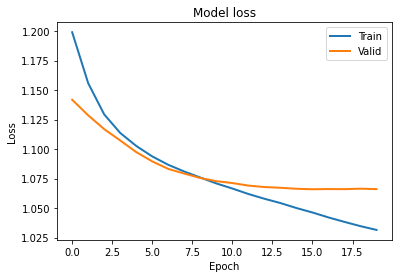

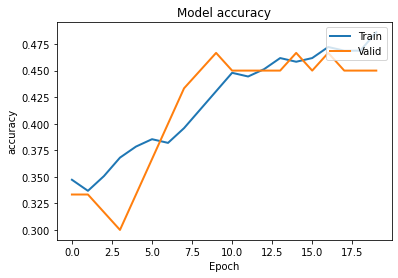

In [636]:
plt.plot(history_3.history['loss'], linewidth=2, label='Train')
plt.plot(history_3.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


plt.plot(history_3.history['accuracy'], linewidth=2, label='Train')
plt.plot(history_3.history['val_accuracy'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.show()

In [637]:
scores = FFN_model_3.evaluate(test_X_sc_array, test_y_bin)
print(scores[1])

2/2 [==============================] - 0s 8ms/step - loss: 1.0309 - accuracy: 0.4889
0.4888888895511627


In [638]:
predictions_future = FFN_model_3.predict(test_X_sc_array)
pred = np.argmax(predictions_future, axis=1)

In [639]:
pred

array([1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [640]:
np.array(test_y)

array([2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2,
       0, 0, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 1, 2, 0, 0, 2, 0, 1, 0,
       2])

accuracy: 48.89%


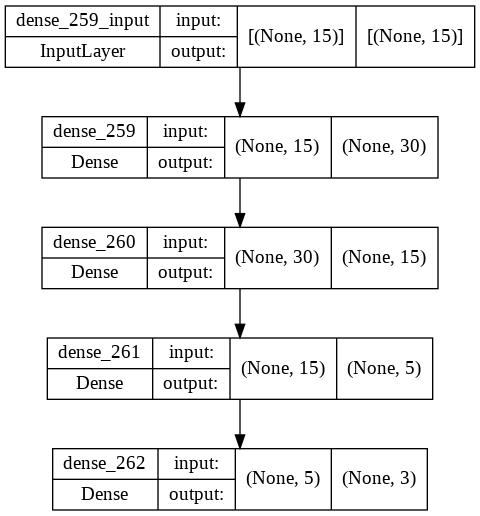

In [642]:
# Сохранение модели
json_file = 'FFN_3_1.json'
model_json = FFN_model_3.to_json()
with open(json_file, 'w') as f:
  f.write(model_json)

# Загрузка модели и присвоение ей сохраненных весов
json_file = open('FFN_3_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("FFN_3_1_weights.h5")

# оценка загруженной модели на тестовых данных
loaded_model.compile(loss='CategoricalCrossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(test_X_sc_array, test_y_bin, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

# Визуализация построенной модели
plot_model(FFN_model_3, to_file='FFN_3_1.png', show_shapes=True, show_layer_names=True)


# Визуализация сохраненных моделей

mae: 9.69


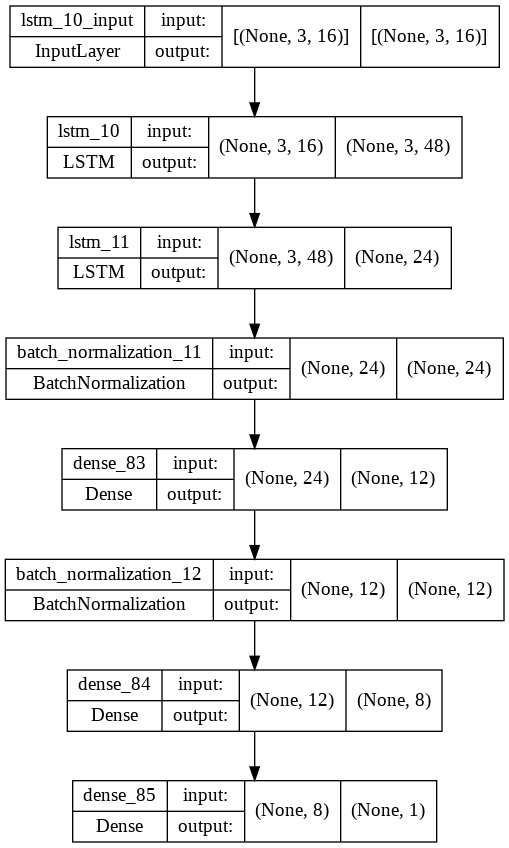

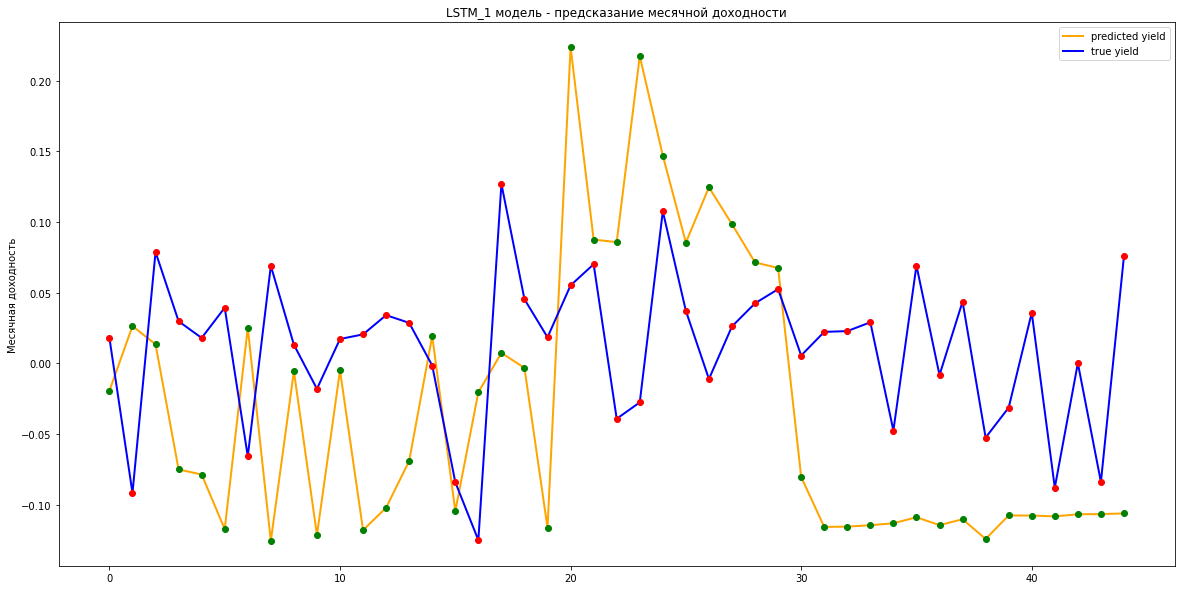

In [833]:
                                                  # LSTM_1 модель. Предсказание месячной доходности

# Загрузка модели и присвоение ей сохраненных весов
LSTM_1_json_file = open('LSTM_1_1.json', 'r')
LSTM_1_loaded_model_json = LSTM_1_json_file.read()
json_file.close()
loaded_LSTM_1 = model_from_json(LSTM_1_loaded_model_json)
loaded_LSTM_1.load_weights("LSTM_1_1_weights.h5")

# оценка загруженной модели на тестовых данных
loaded_LSTM_1.compile(loss='mse', optimizer=adam, metrics=['mae'])               # сбор сохраненной модели
score = loaded_LSTM_1.evaluate(test_X_scaled, test_y, verbose=0)                 # оценка сохраненной модели
print("%s: %.2f" % (loaded_LSTM_1.metrics_names[1], score[1]*100))

# График сравнения предсказаний и фактических данных
x = range(test_y.shape[0])
plt.figure(figsize=(20,10))
plt.plot(loaded_LSTM_1.predict(test_X_scaled), color='orange', label='predicted yield', linewidth=2) 
plt.plot(test_y, color='blue', label='true yield', linewidth=2)
plt.legend(loc='upper right')
plt.title('LSTM_1 модель - предсказание месячной доходности')
plt.ylabel('Месячная доходность')
plt.plot(x, test_y, 'o', color='red')                                            #Синяя линия - фактические значения
plt.plot(x, loaded_LSTM_1.predict(test_X_scaled), 'o', color='green')            #Желтая линия - предсказание
plt.savefig('LSTM_1_1_graph.png')


# Визуализация построенной модели
plot_model(loaded_LSTM_1, to_file='LSTM_1_1.png', show_shapes=True, show_layer_names=True)


mae: 36995.82


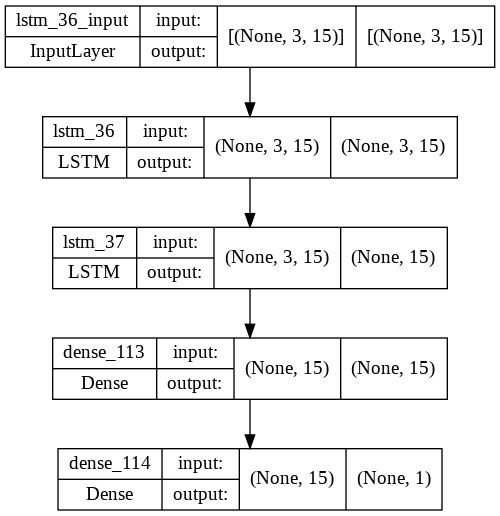

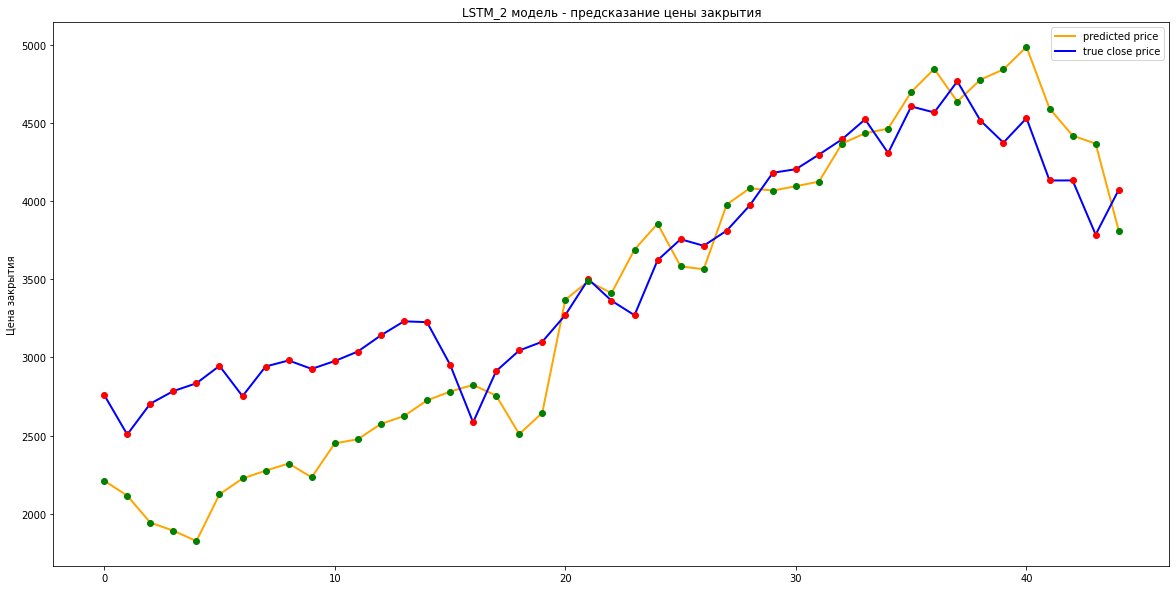

In [843]:
                                                  # LSTM_2 модель. Предсказание цены закрыти 

# Загрузка модели и присвоение ей сохраненных весов
LSTM_2_json_file = open('LSTM_2_1.json', 'r')
LSTM_2_loaded_model_json = LSTM_2_json_file.read()
json_file.close()
loaded_LSTM_2 = model_from_json(LSTM_2_loaded_model_json)
loaded_LSTM_2.load_weights("LSTM_2_1_weights.h5")

# оценка загруженной модели на тестовых данных
loaded_LSTM_2.compile(loss='mse', optimizer=adam, metrics=['mae'])               # сбор сохраненной модели
score = loaded_LSTM_2.evaluate(test_X_scaled, test_y, verbose=0)                 # оценка сохраненной модели
print("%s: %.2f" % (loaded_LSTM_2.metrics_names[1], score[1]*100))

# График сравнения предсказаний и фактических данных
x = range(test_y.shape[0])
plt.figure(figsize=(20,10))
plt.plot(loaded_LSTM_2.predict(test_X_scaled), color='orange', label='predicted price', linewidth=2) 
plt.plot(test_y, color='blue', label='true close price', linewidth=2)
plt.legend(loc='upper right')
plt.title('LSTM_2 модель - предсказание цены закрытия')
plt.ylabel('Цена закрытия')
plt.plot(x, test_y, 'o', color='red')                                            #Синяя линия - фактические значения
plt.plot(x, loaded_LSTM_2.predict(test_X_scaled), 'o', color='green')            #Желтая линия - предсказание
plt.savefig('LSTM_2_1_graph.png')

# Визуализация построенной модели
plot_model(loaded_LSTM_2, to_file='LSTM_2_1.png', show_shapes=True, show_layer_names=True)


mae: 4.95


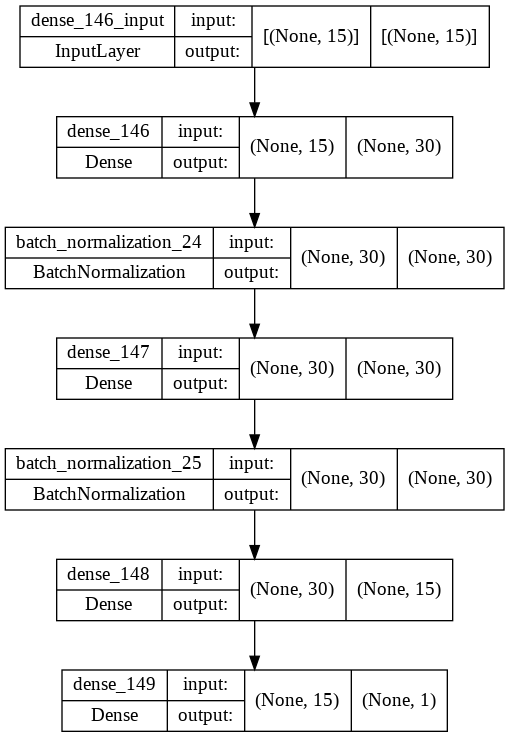

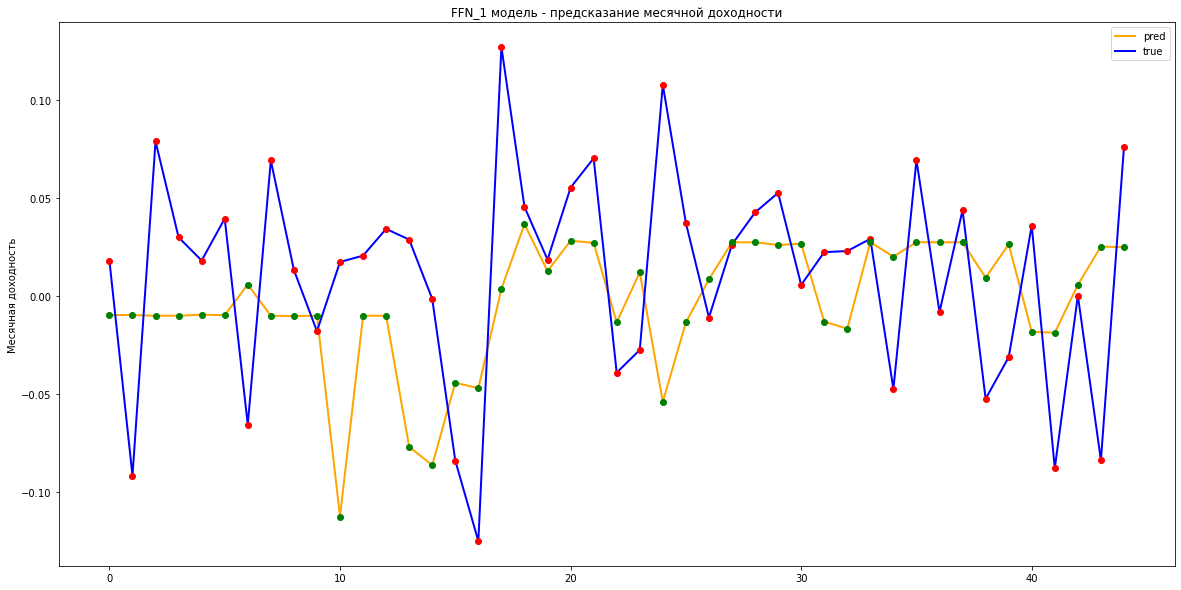

In [851]:
                                                  # FFN_1 модель. Предсказание месячной доходности

# Загрузка модели и присвоение ей сохраненных весов
FFN_1_json_file = open('FFN_1_1.json', 'r')
FFN_1_loaded_model_json = FFN_1_json_file.read()
json_file.close()
loaded_FFN_1 = model_from_json(FFN_1_loaded_model_json)
loaded_FFN_1.load_weights("FFN_1_1_weights.h5")

# оценка загруженной модели на тестовых данных
loaded_FFN_1.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])               # сбор сохраненной модели
score = loaded_FFN_1.evaluate(test_X_sc_array, test_y_array, verbose=0)                                               # оценка сохраненной модели
print("%s: %.2f" % (loaded_FFN_1.metrics_names[1], score[1]*100))


# График сравнения предсказаний и фактических данных
x = range(test_y_array.shape[0])
plt.figure(figsize=(20,10))
plt.plot(loaded_FFN_1.predict(test_X_sc_array), color='orange', label='pred', linewidth=2) 
plt.plot(test_y_array, color='blue', label='true', linewidth=2)
plt.legend(loc='upper right')
plt.title('FFN_1 модель - предсказание месячной доходности')
plt.ylabel('Месячная доходность')
plt.plot(x, test_y_array, 'o', color='red')                                       #Синяя линия - фактические значения
plt.plot(x, loaded_FFN_1.predict(test_X_sc_array), 'o', color='green')            #Желтая линия - предсказание
plt.savefig('FFN_1_1_graph.png')

# Визуализация построенной модели
plot_model(loaded_FFN_1, to_file='FFN_1_1.png', show_shapes=True, show_layer_names=True)


mae: 30707.11


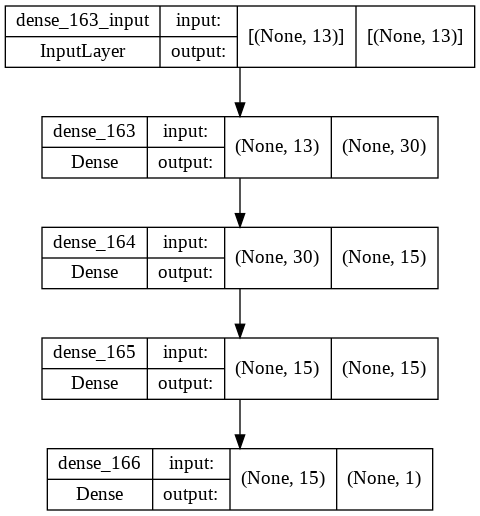

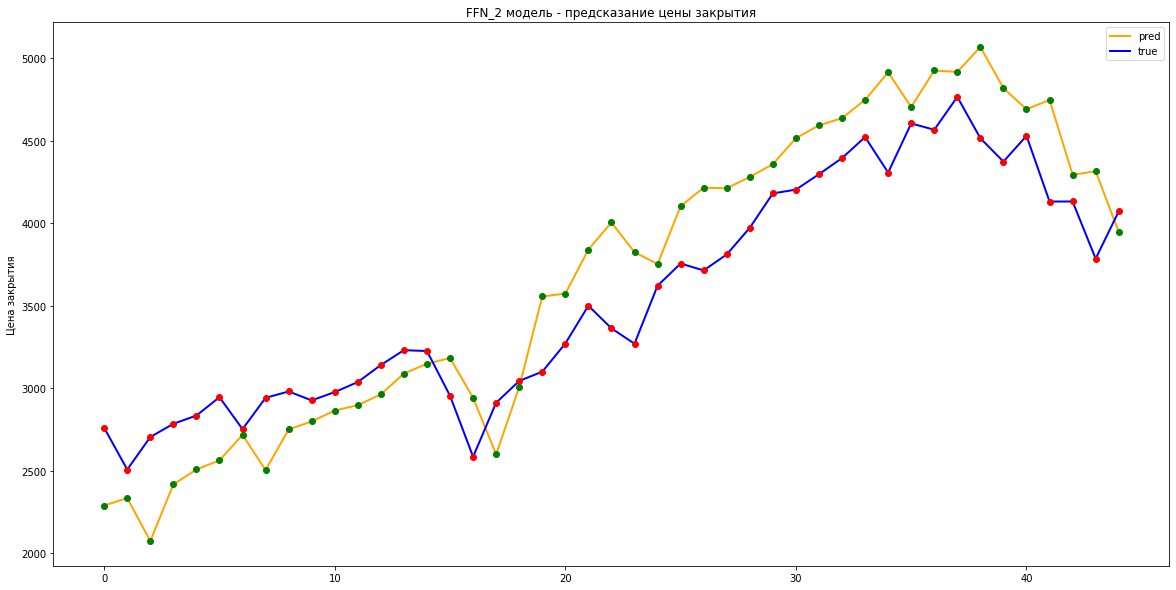

In [860]:
                                                  # FFN_2 модель. Предсказание цены закрытия

# Загрузка модели и присвоение ей сохраненных весов
FFN_2_json_file = open('FFN_2_1.json', 'r')
FFN_2_loaded_model_json = FFN_2_json_file.read()
json_file.close()
loaded_FFN_2 = model_from_json(FFN_2_loaded_model_json)
loaded_FFN_2.load_weights("FFN_2_1_weights.h5")

# оценка загруженной модели на тестовых данных
loaded_FFN_2.compile(loss='mse', optimizer= keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])               # сбор сохраненной модели
score = loaded_FFN_2.evaluate(test_X_sc_array, test_y_array, verbose=0)                                               # оценка сохраненной модели
print("%s: %.2f" % (loaded_FFN_2.metrics_names[1], score[1]*100))


# График сравнения предсказаний и фактических данных
x = range(test_y_array.shape[0])
plt.figure(figsize=(20,10))
plt.plot(loaded_FFN_2.predict(test_X_sc_array), color='orange', label='pred', linewidth=2) 
plt.plot(test_y_array, color='blue', label='true', linewidth=2)
plt.plot(x, test_y_array, 'o', color='red')                                       #Синяя линия - фактические значения
plt.plot(x, loaded_FFN_2.predict(test_X_sc_array), 'o', color='green')            #Желтая линия - предсказание
plt.legend(loc='upper right')
plt.title('FFN_2 модель - предсказание цены закрытия')
plt.ylabel('Цена закрытия')
plt.savefig('FFN_2_1_graph.png')

# Визуализация построенной модели
plot_model(loaded_FFN_2, to_file='FFN_2_1.png', show_shapes=True, show_layer_names=True)

accuracy: 51.11%


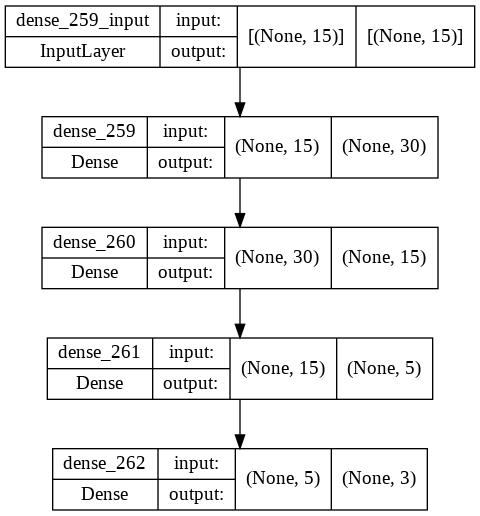

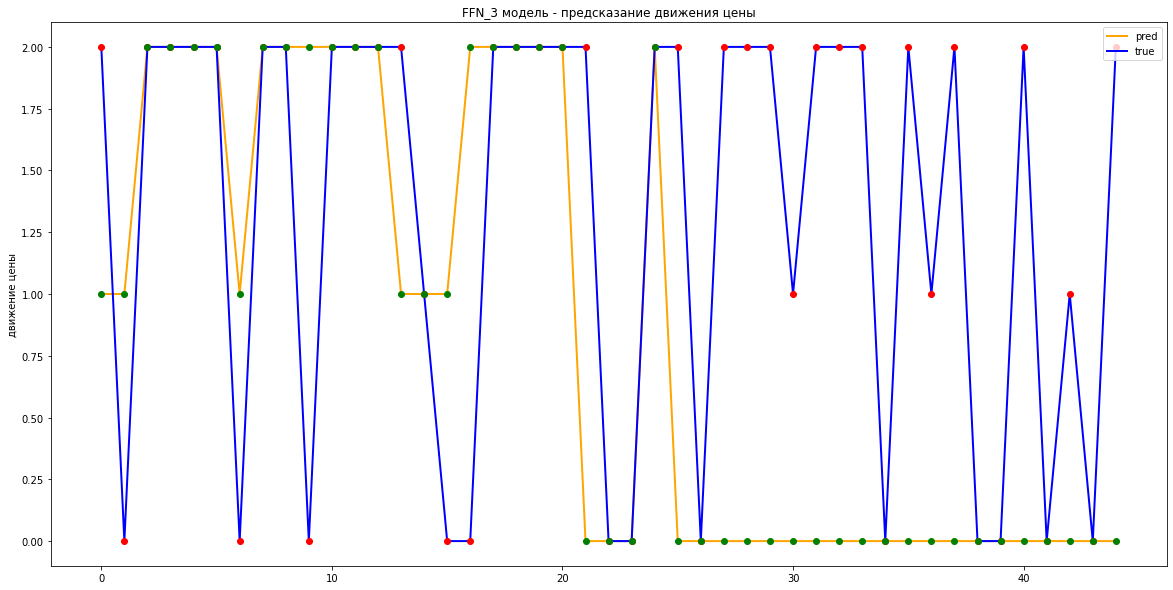

In [823]:
                                                  # FFN_3 модель. Предсказание движения цены закрытия
                                 # Отметки: "2" -рост больше чем на 1%, "0" - падение цены больше чем на 1%, "1" - цена не изменится

# Загрузка модели и присвоение ей сохраненных весов
FFN_3_json_file = open('FFN_3_1.json', 'r')
FFN_3_loaded_model_json = FFN_3_json_file.read()
json_file.close()
loaded_FFN_3 = model_from_json(FFN_3_loaded_model_json)
loaded_FFN_3.load_weights("FFN_3_1_weights.h5")



# оценка загруженной модели на тестовых данных
loaded_FFN_3.compile(loss='CategoricalCrossentropy', 
                     optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])                   # сбор сохраненной модели
score = loaded_FFN_3.evaluate(test_X_sc_array, test_y_bin, verbose=0)                                               # оценка сохраненной модели
print("%s: %.2f%%" % (loaded_FFN_3.metrics_names[1], score[1]*100))

prediction_movement = np.argmax(loaded_FFN_3.predict(test_X_sc_array),axis=1)

# График сравнения предсказаний и фактических данных
x = range(np.array(test_y).shape[0])
plt.figure(figsize=(20,10))
plt.plot(prediction_movement, color='orange', label='pred', linewidth=2) 
plt.plot(np.array(test_y), color='blue', label='true', linewidth=2)
plt.plot(x, np.array(test_y), 'o', color='red')                                  #Синяя линия - фактические значения
plt.plot(x, prediction_movement, 'o', color='green')            #Желтая линия - предсказание
plt.legend(loc='upper right')
plt.title('FFN_3 модель - предсказание движения цены')
plt.ylabel('движение цены')  

plt.savefig('FFN_3_1_graph.png')

# Визуализация построенной модели
plot_model(loaded_FFN_3, to_file='FFN_3_1.png', show_shapes=True, show_layer_names=True)